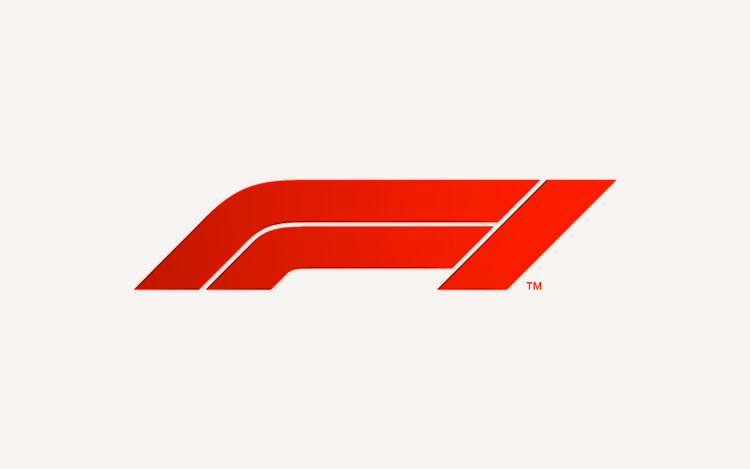

In [1]:
# !pip install fastf1

In [2]:
!python -V 

Python 3.7.12


In [3]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings
from datetime import datetime, date, time
import ipywidgets as widgets
import pdb
# import fastf1
import glob
import os
import getpass
import sys


print('Libraries imported')

Libraries imported


In [4]:
# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

print('Notebook configured')

Notebook configured


In [5]:
df_drivers = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv')

In [6]:
df_laptimes = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv')

In [7]:
df_races = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/races.csv')

In [8]:
df_pitstops = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv')

In [9]:
df_results = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/results.csv')

In [10]:
df = pd.merge(df_laptimes,df_drivers[['driverId','code','driverRef']],how='left',on='driverId')
df = pd.merge(df,df_races[['raceId','name','date','year']],how='left',on='raceId')

In [11]:
df['time']=pd.to_timedelta(df['milliseconds'], unit='ms')
df['seconds']=df['milliseconds']/1000

In [12]:
df.head()

raceId  driverId  lap  position                   time  milliseconds code driverRef                   name        date  year  seconds
0     841        20    1         1 0 days 00:01:38.109000         98109  VET    vettel  Australian Grand Prix  2011-03-27  2011   98.109
1     841        20    2         1 0 days 00:01:33.006000         93006  VET    vettel  Australian Grand Prix  2011-03-27  2011   93.006
2     841        20    3         1 0 days 00:01:32.713000         92713  VET    vettel  Australian Grand Prix  2011-03-27  2011   92.713
3     841        20    4         1 0 days 00:01:32.803000         92803  VET    vettel  Australian Grand Prix  2011-03-27  2011   92.803
4     841        20    5         1 0 days 00:01:32.342000         92342  VET    vettel  Australian Grand Prix  2011-03-27  2011   92.342

In [13]:
from tqdm import tqdm

<a id='2'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Lap Analysis</b>

The lap analyses rummages through each race's laptimes and positions. Each race has a story of how the lap times generally decrease over the course of the race as the fuel load gets less, and increases between pitstops as the tires wear. The pitstops are not always apparent, as the low laptimes might as well be safety cars (this is usually when the two champions have the same slow lap times together).  

The pitstop strategies here are also interesting as one usually tries to undercut the other, i.e. pits earlier, and then runs faster on the new tires to try and get ahead of the other by the time his pitstop comes. Strategy and tire management is crucial to win races.

Note also that sometimes toward the end of a race that one could pit in an attempt to get the fastest lap, which is an additional point. 

In [14]:
df_laps = df[(df['year']==2021)&((df['code']=='VER')|(df['code']=='HAM'))].copy()
df_laps.rename(columns={'position':'lap position'},inplace=True)
df_laps = df_laps.merge(df_results[['raceId','driverId','position']],how='left',on=['raceId','driverId'])
df_laps = df_laps.merge(df_pitstops[['raceId','driverId','lap','stop']],how='left',on=['raceId','driverId','lap'])
df_laps['stop'].fillna(0,inplace=True)
df_laps['stop']=df_laps['stop'].astype(int)
df_laps['stop'][df_laps['stop']==0] = ''

In [15]:
df_laps.head()

raceId  driverId  lap  lap position                   time  milliseconds code       driverRef                name        date  year  seconds position stop
0    1052       830    1             1 0 days 00:01:58.245000        118245  VER  max_verstappen  Bahrain Grand Prix  2021-03-28  2021  118.245        2     
1    1052       830    2             1 0 days 00:02:22.406000        142406  VER  max_verstappen  Bahrain Grand Prix  2021-03-28  2021  142.406        2     
2    1052       830    3             1 0 days 00:02:38.001000        158001  VER  max_verstappen  Bahrain Grand Prix  2021-03-28  2021  158.001        2     
3    1052       830    4             1 0 days 00:01:44.343000        104343  VER  max_verstappen  Bahrain Grand Prix  2021-03-28  2021  104.343        2     
4    1052       830    5             1 0 days 00:01:44.629000        104629  VER  max_verstappen  Bahrain Grand Prix  2021-03-28  2021  104.629        2

First up is the lap times (in seconds). The charts are annotated with the pitstop numbers for each racer. The pitstop annotations are not always at the peaks, as they might have crossed the finish line in the pitstop. Usually this gives you a slightly slower lap time followed by a much slower laptime. 

We do not know where the safety cars were deployed, but we can expect them at the slow laptimes where there are no pitstops indicated.

Note how much faster they are after each pitstop and how the laptime from then on seems to remain more or less constant, or even slows down. The is the tug of war between reducing fuel weight vs tire wear. 

22it [00:04,  4.40it/s]


<Figure size 720x7200 with 0 Axes>

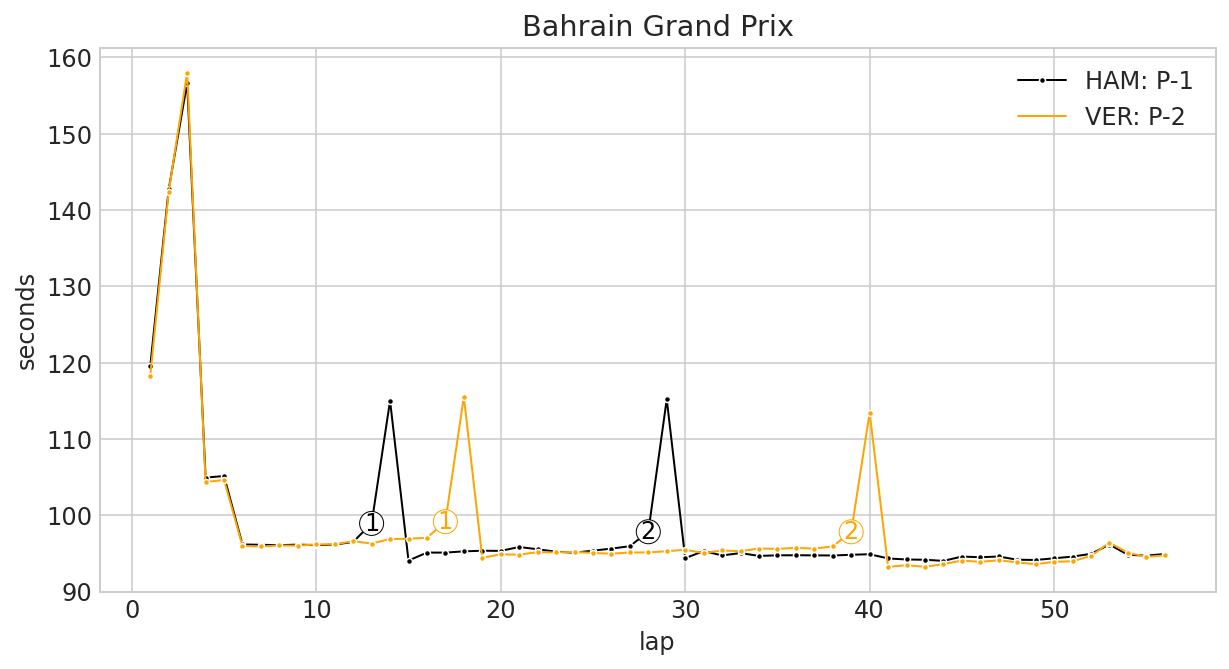

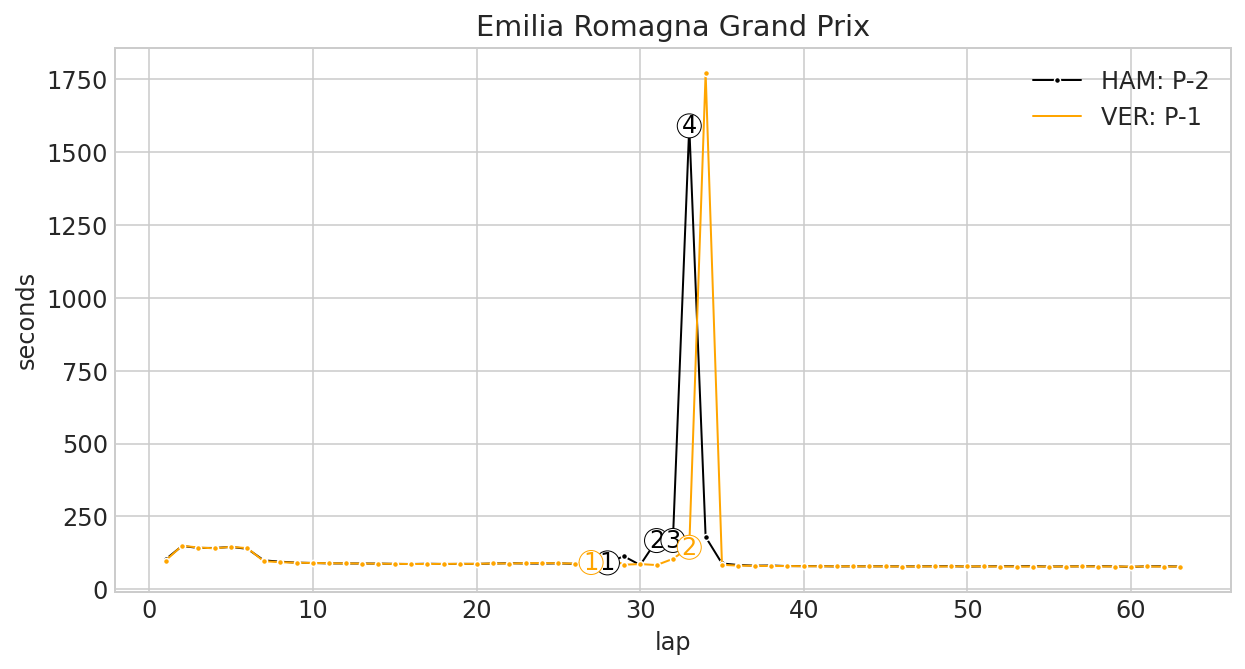

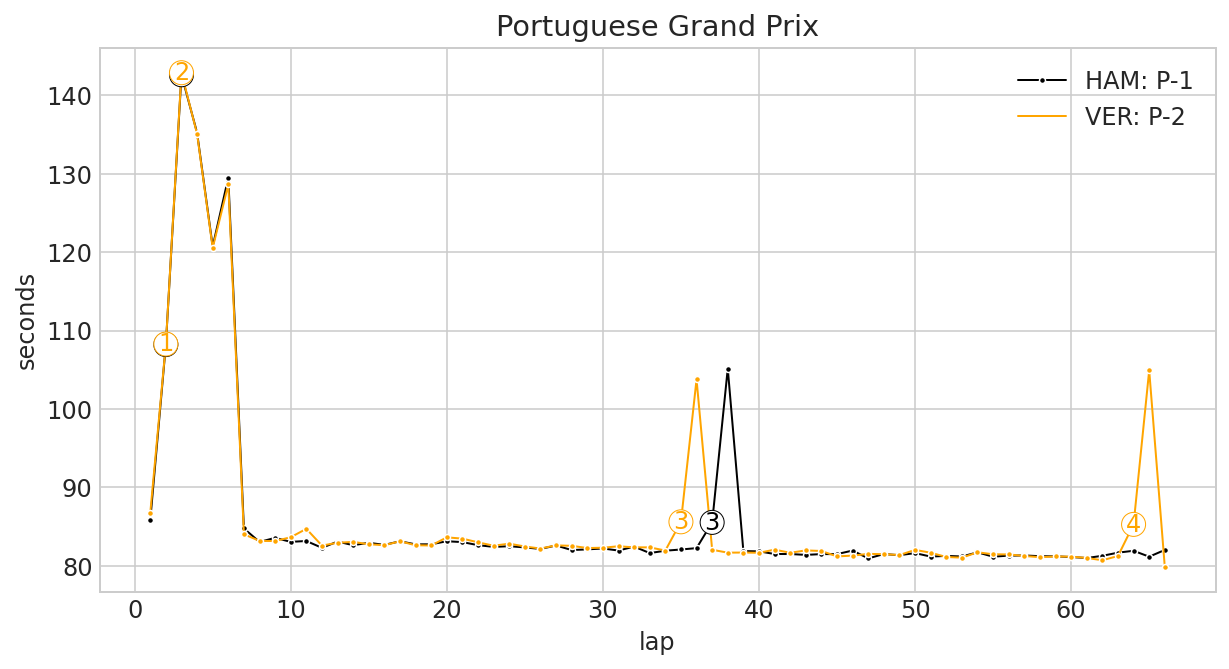

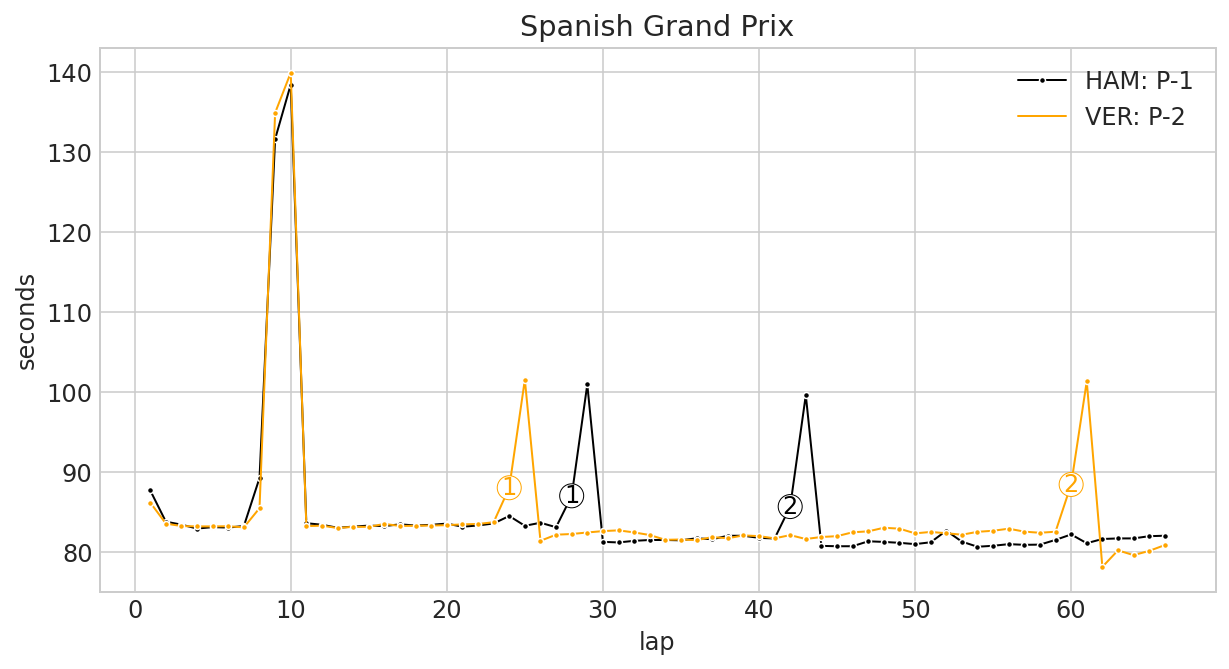

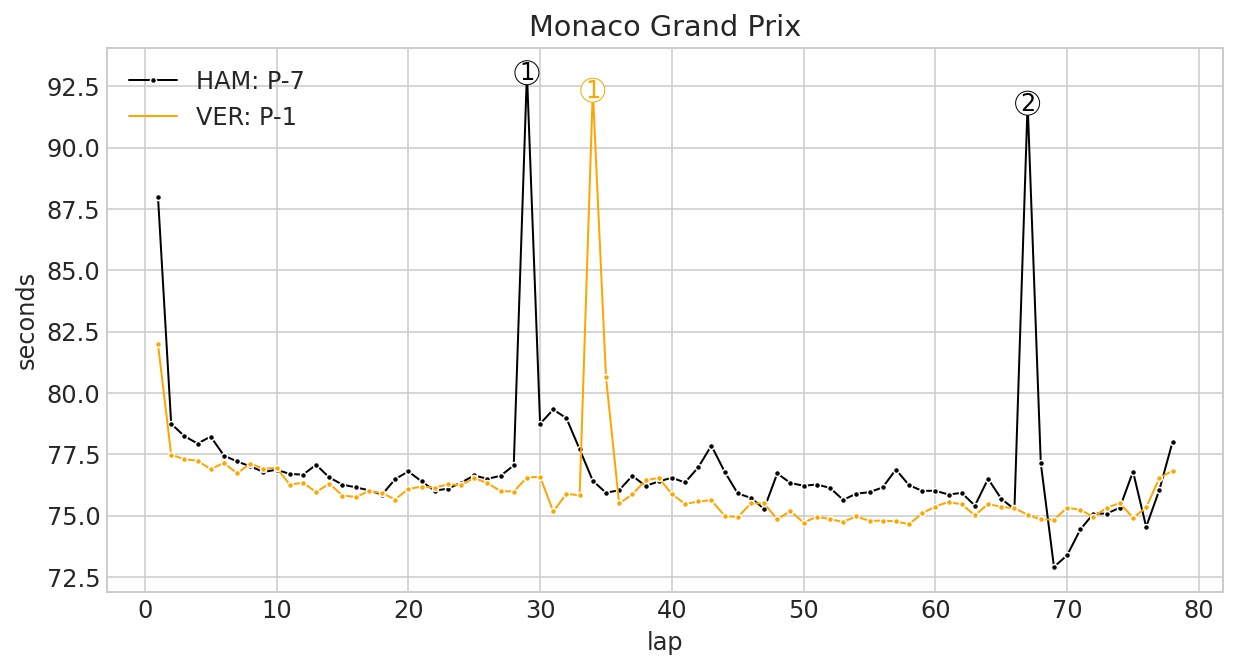

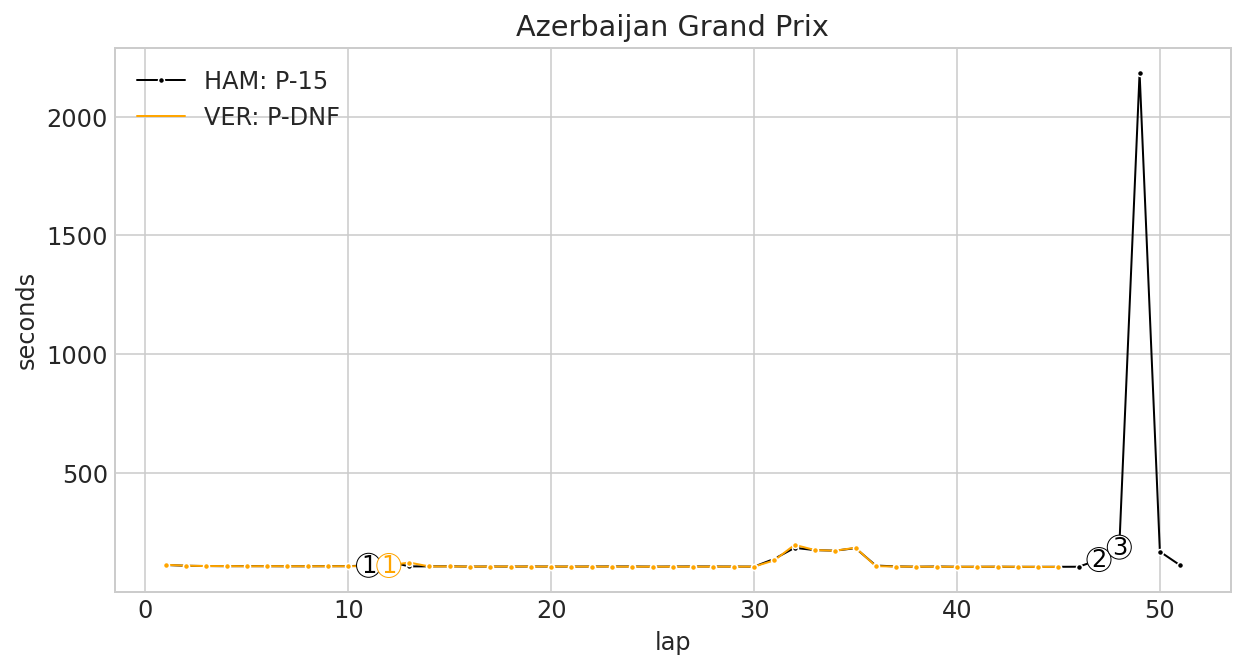

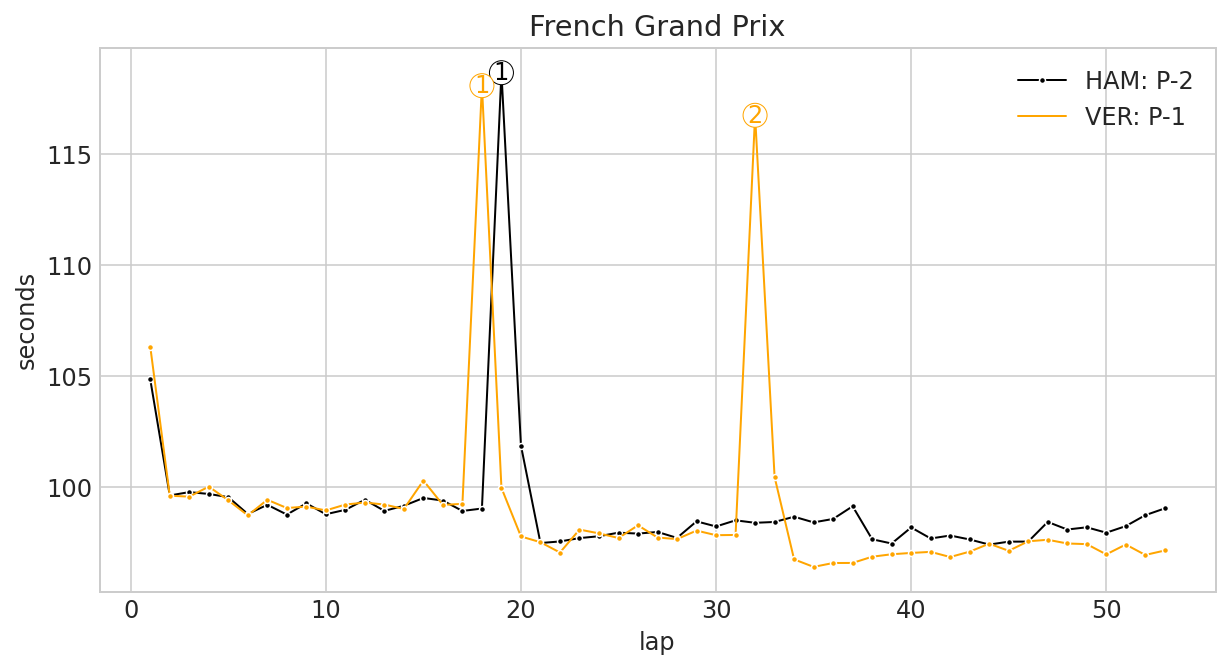

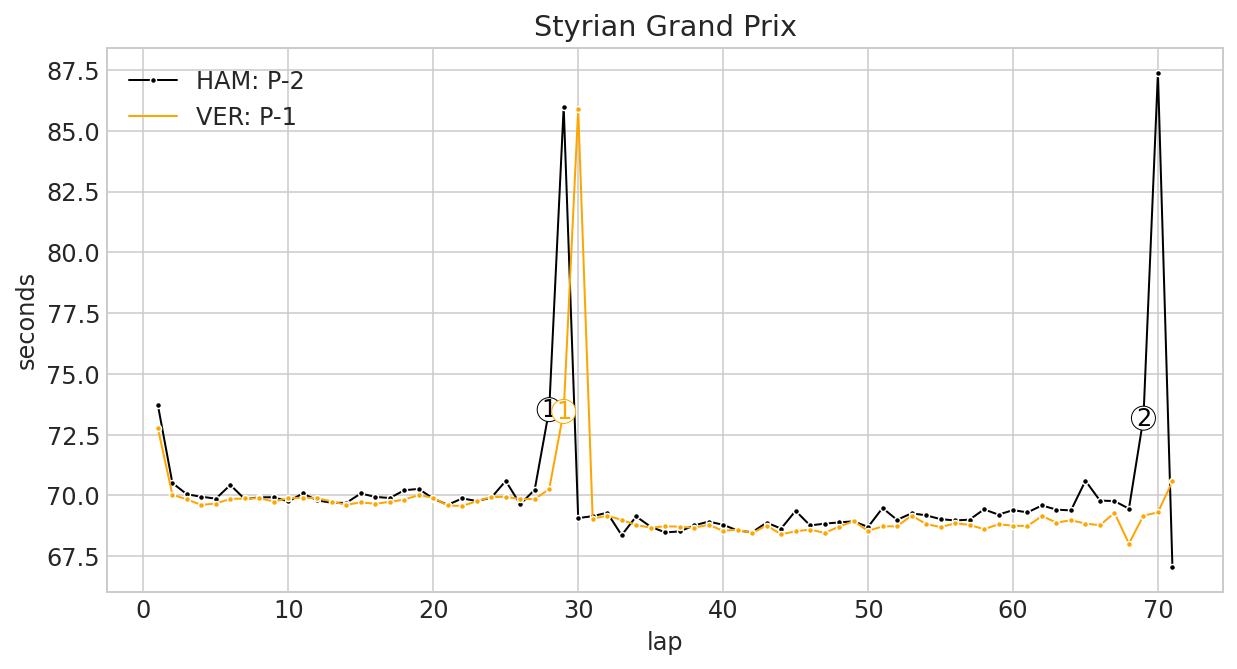

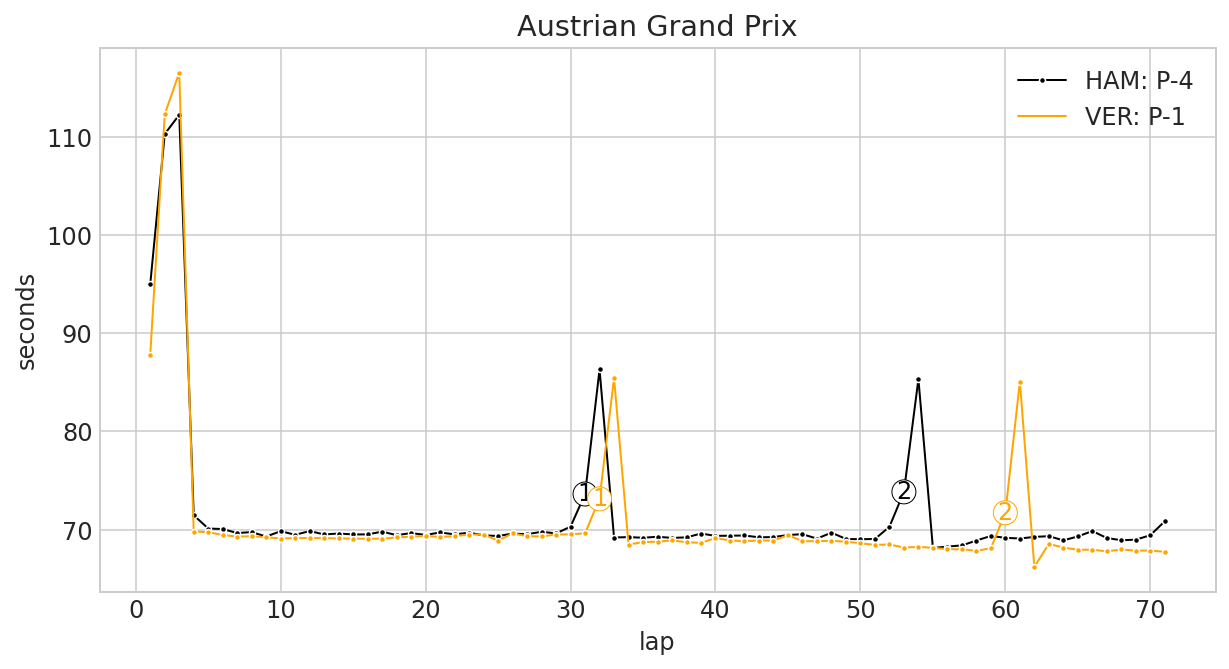

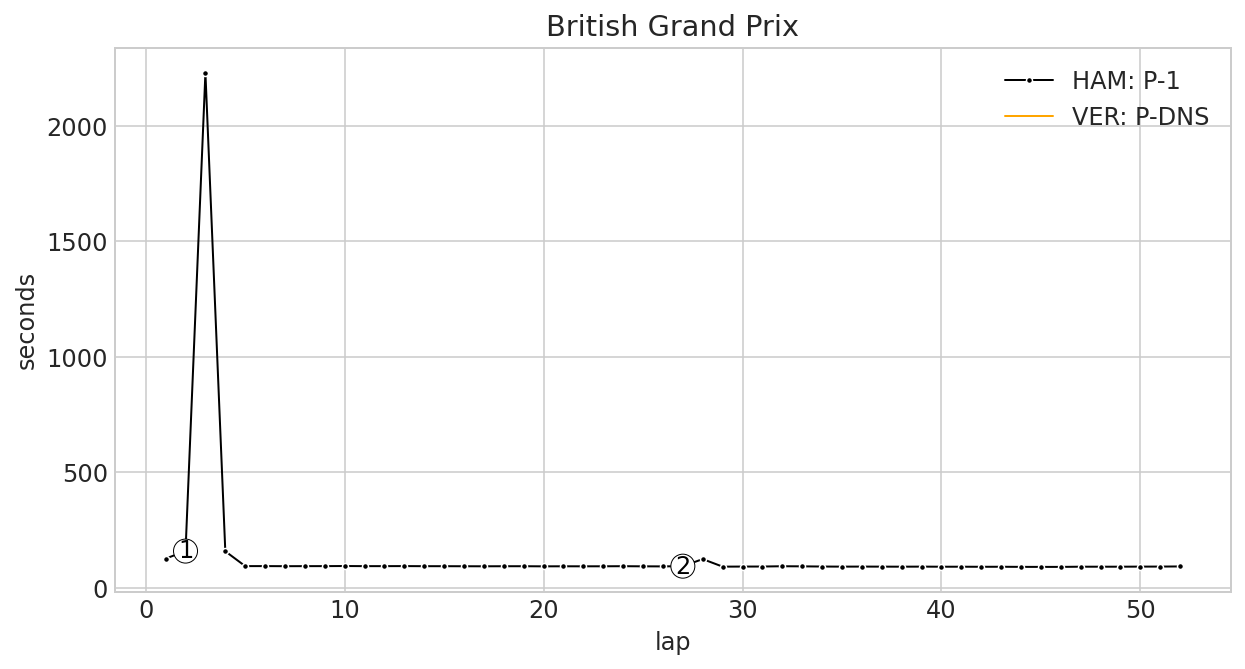

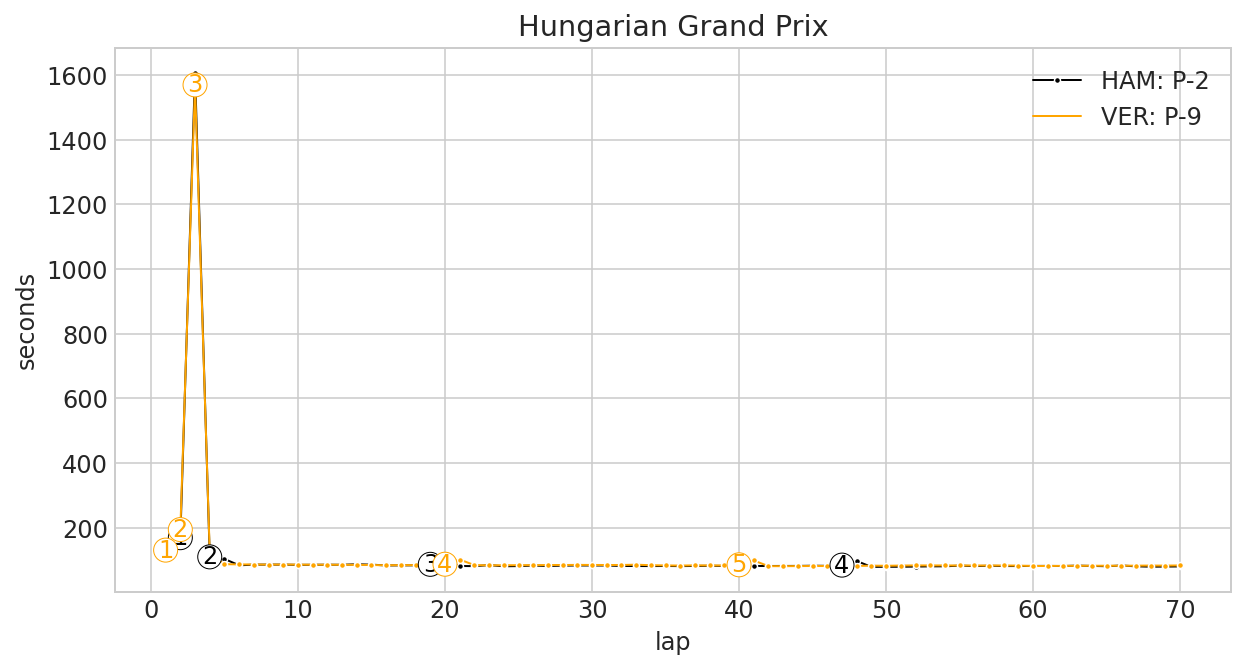

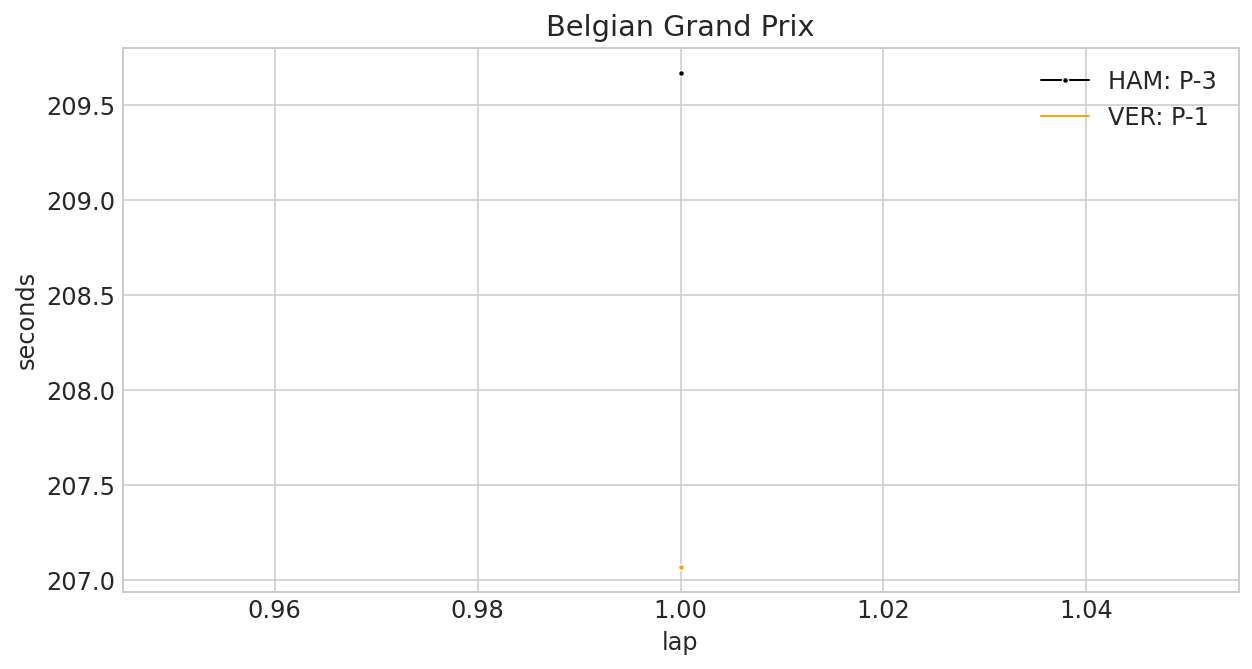

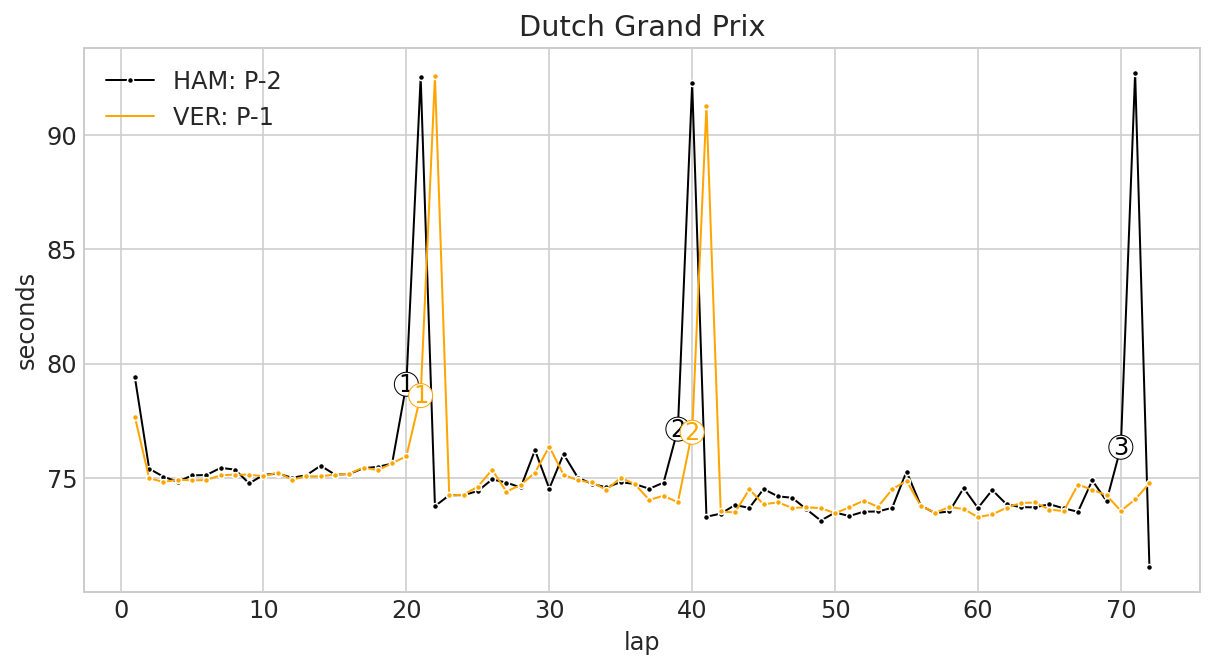

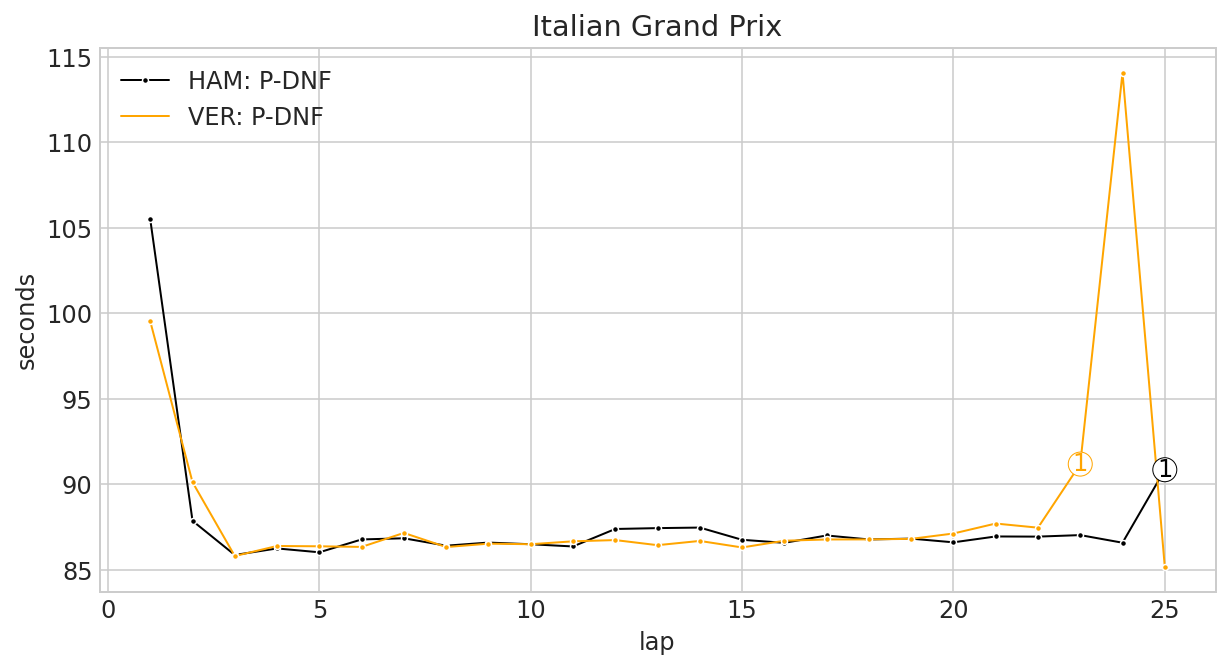

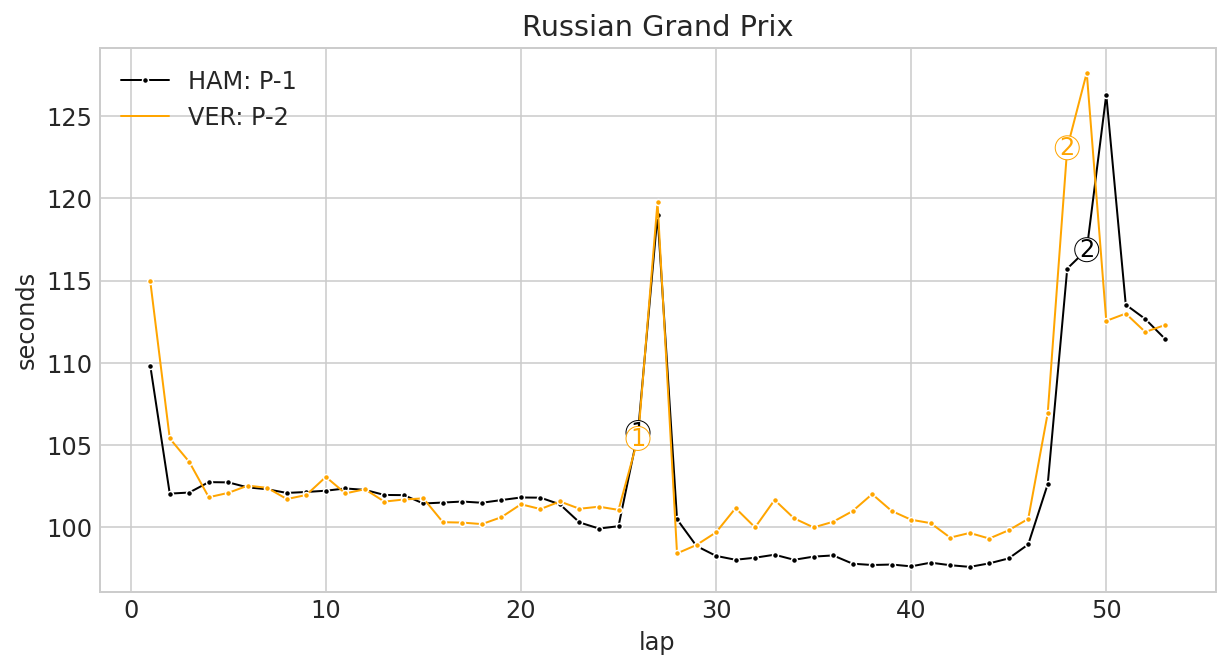

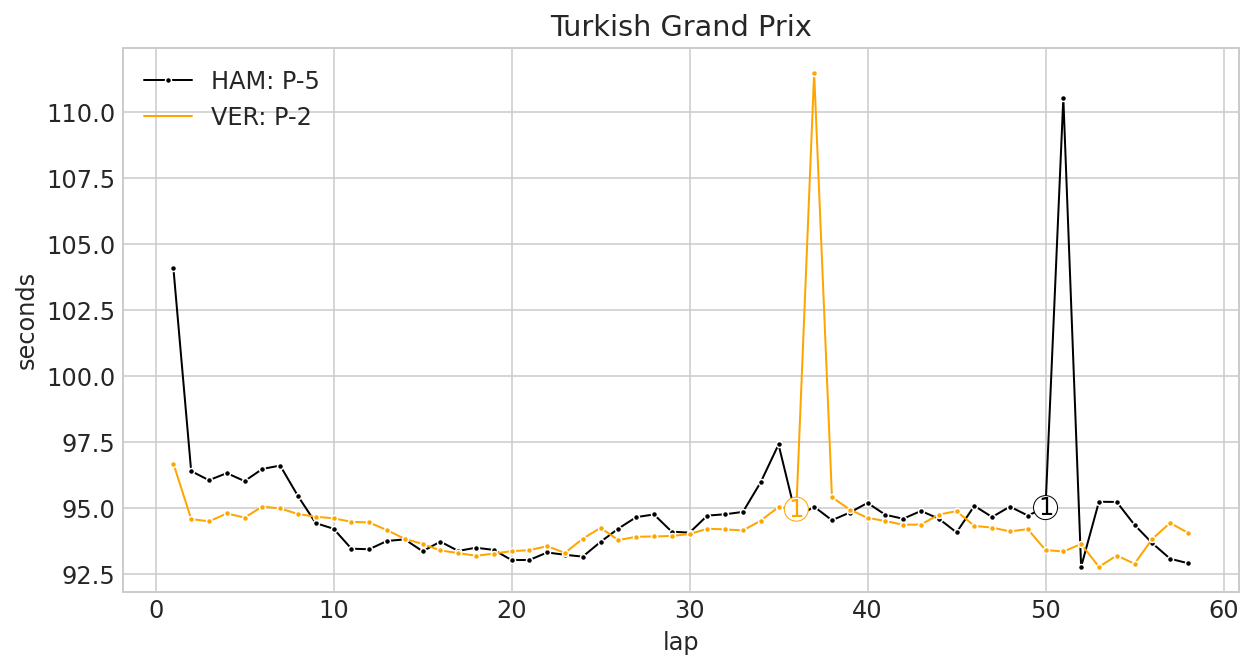

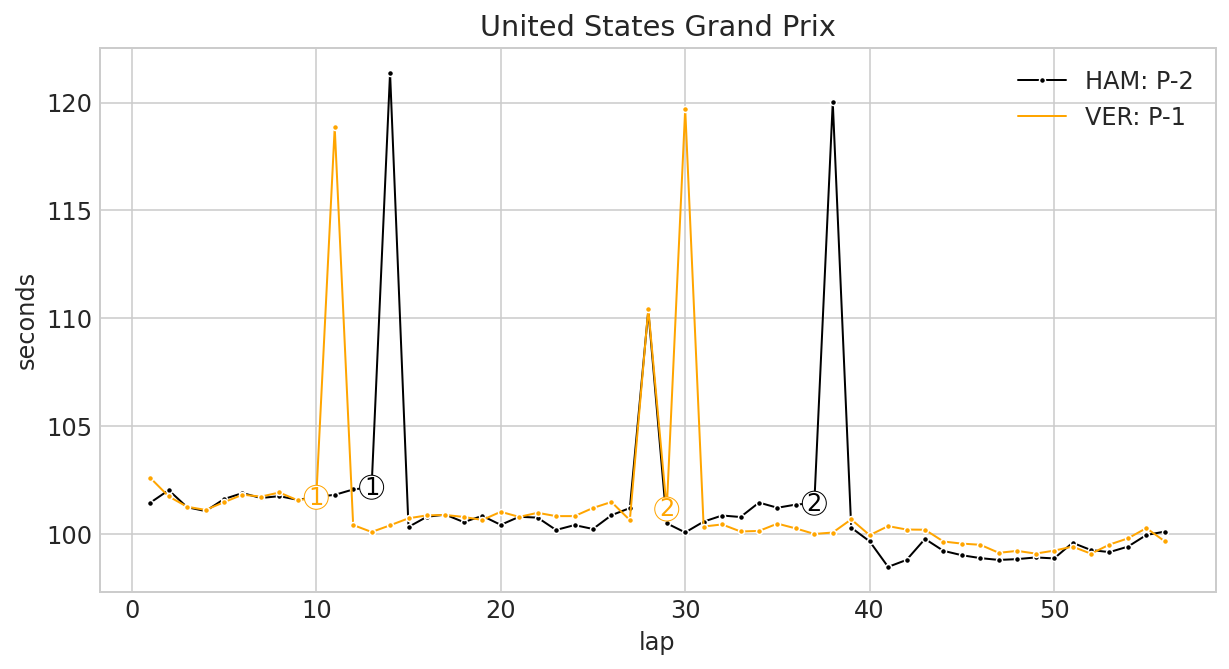

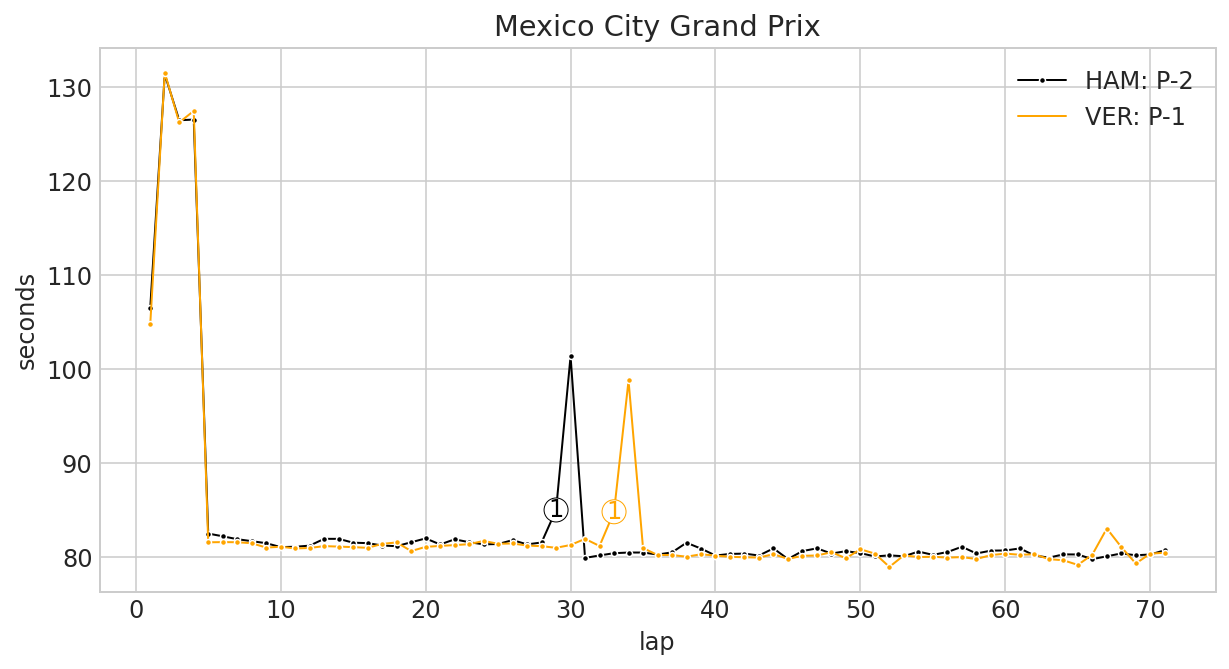

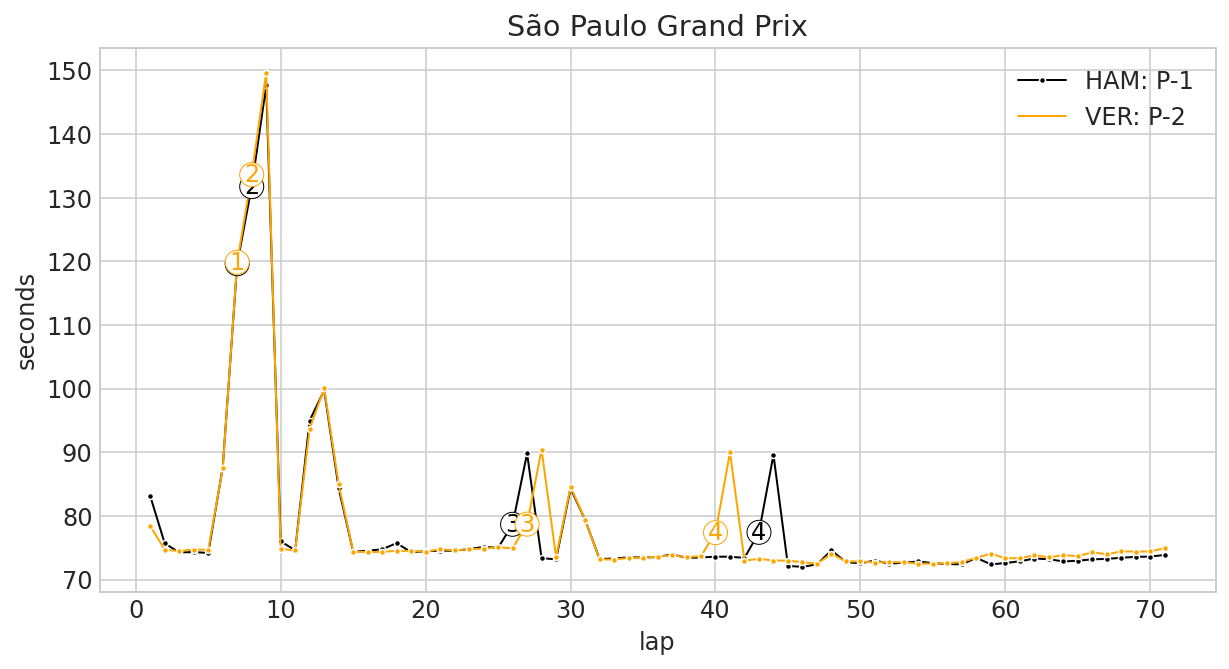

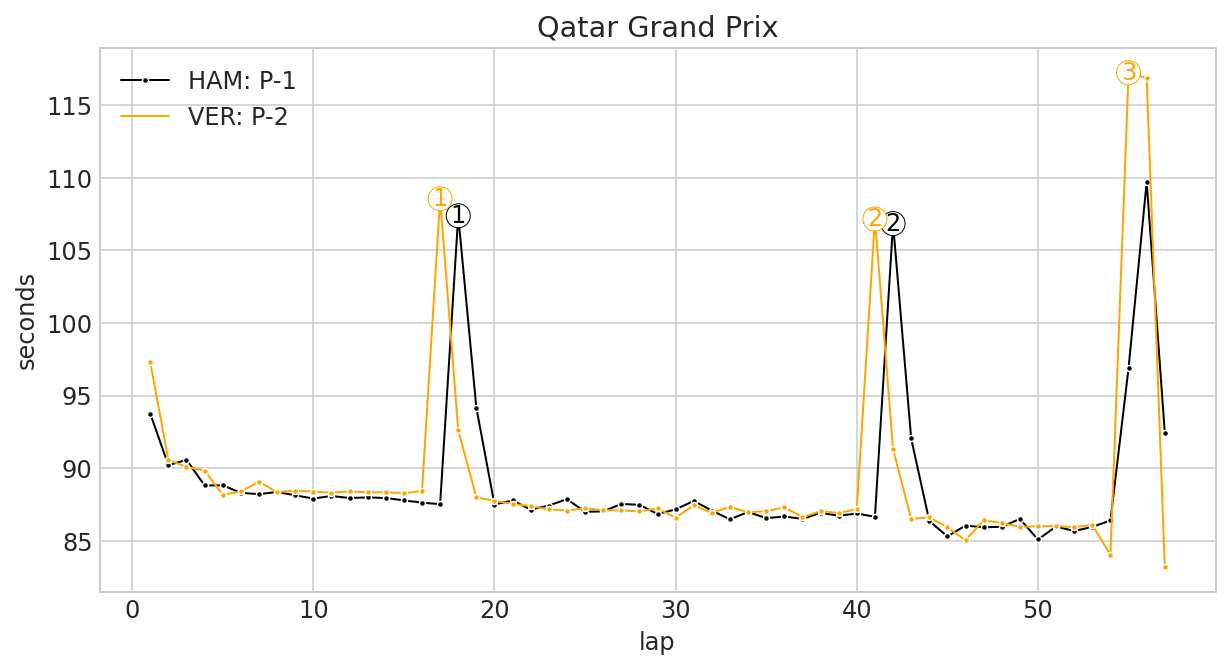

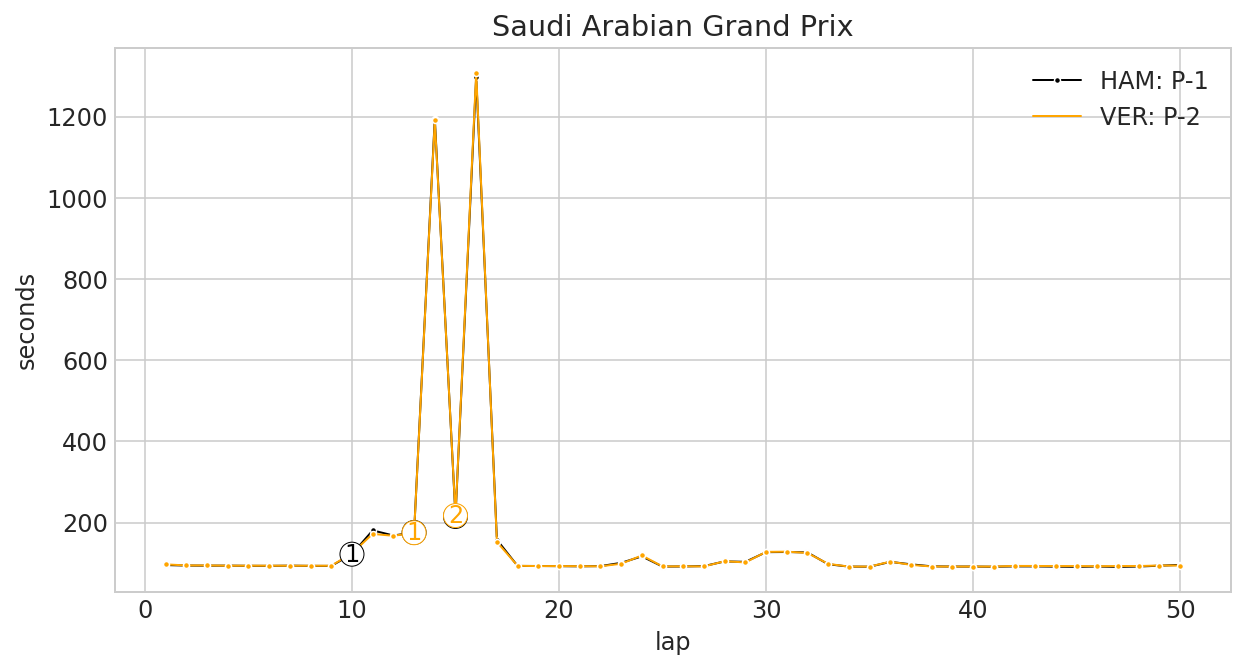

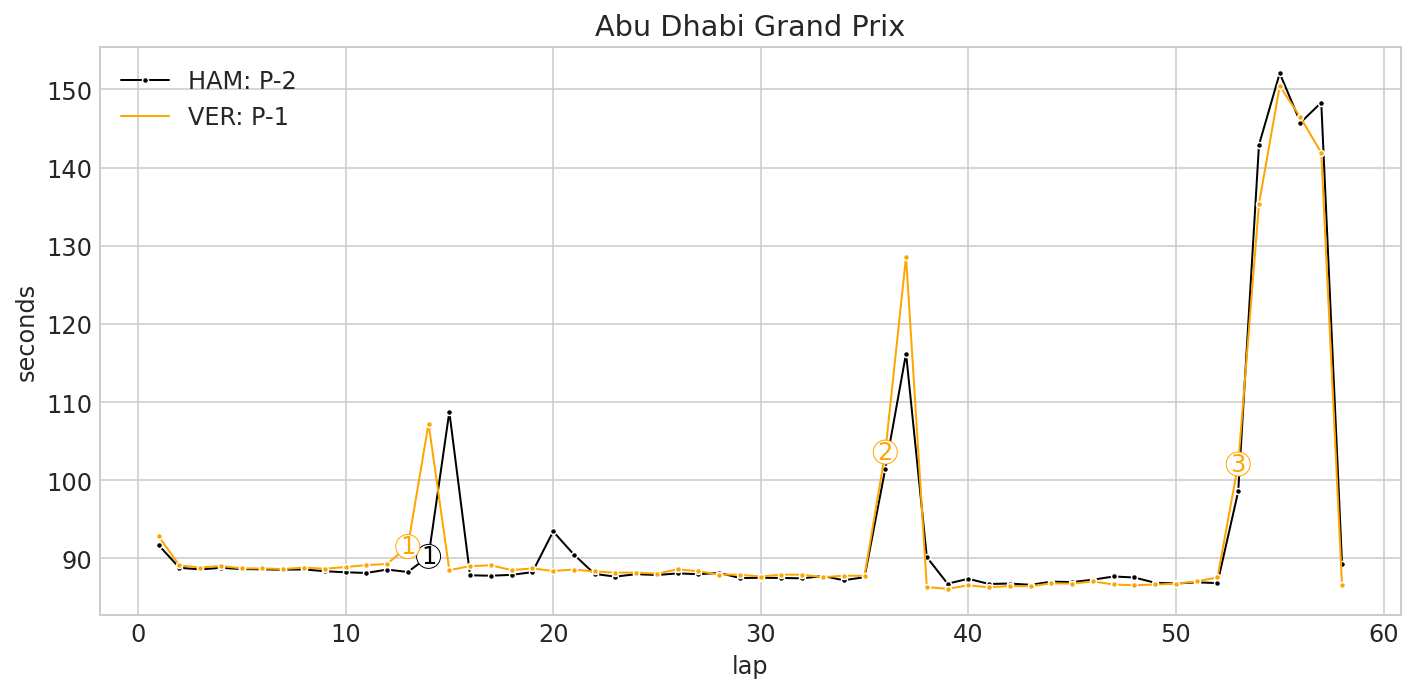

In [16]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=10,5 
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.labelsize']=12
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12

plt.figure(figsize=(10, 100))
for i, f in tqdm(enumerate(df_laps['name'].unique())):
    try:
        HAM_pos = list(set(df_laps[(df_laps['name']==f)&(df_laps['code']=='HAM')]['position']))[0]
        if HAM_pos == r'\N':
            HAM_pos = 'DNF'
    except:
        HAM_pos = 'DNS'
    try:    
        VER_pos = list(set(df_laps[(df_laps['name']==f)&(df_laps['code']=='VER')]['position']))[0]
        if VER_pos == r'\N':
            VER_pos = 'DNF'
    except:
        VER_pos = 'DNS'
    fig,ax = plt.subplots(1,1)
    plt.title(f)
    sns.lineplot(data=df_laps[(df_laps['name']==f)&(df_laps['code']=='HAM')],
                 x='lap', 
                 y='seconds',
                 hue='code',
                 palette=['black'],
                 ax=ax,
                 marker='.',
                 # marker_size=3
                )
    HAM_stops = df_laps[(df_laps['name']==f)&(df_laps['code']=='HAM')]
    for j,label in enumerate(HAM_stops['stop']):
        plt.annotate(label, (HAM_stops['lap'].iloc[j], 
                             HAM_stops['seconds'].iloc[j]
                            ), 
                     color = 'black',
                     bbox=dict(boxstyle="circle,pad=0", fc="white", ec="black", lw=0.5),
                     ha="center", va="center",
                    )
    
    sns.lineplot(data=df_laps[(df_laps['name']==f)&(df_laps['code']=='VER')],
                 x='lap', 
                 y='seconds',
                 hue='code',
                 ax=ax,
                 palette = ['orange'],
                 marker='.',
                )
    
    VER_stops = df_laps[(df_laps['name']==f)&(df_laps['code']=='VER')]
    for j,label in enumerate(VER_stops['stop']):
        plt.annotate(label, (VER_stops['lap'].iloc[j], 
                             VER_stops['seconds'].iloc[j]
                            ),
                     color='orange',
                     bbox=dict(boxstyle="circle,pad=0", fc="white", ec="orange", lw=0.5),
                     ha="center", va="center",
                    )
    
    if ax.get_legend_handles_labels()[1][0]=='HAM':
        plt.legend(['HAM: P-'+str(HAM_pos), 'VER: P-'+str(VER_pos)])
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('black')
        leg.legendHandles[1].set_color('orange')
    elif ax.get_legend_handles_labels()[1][0]=='VER':
        plt.legend(['VER: P-'+str(VER_pos), 'HAM: P-'+str(HAM_pos)])
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('orange')
        leg.legendHandles[1].set_color('black')
        
        
plt.tight_layout()
plt.show()

Next up is the position of the drivers throughout the race. The pitstops are annotated again to see how this influenced their positions. The starting position obviously shows where the drivers ended in qualifying. Maybe in later edits of this notebook I'll look at conversion factors or positions of qualifying vs race result. 

22it [00:05,  4.24it/s]


<Figure size 720x7200 with 0 Axes>

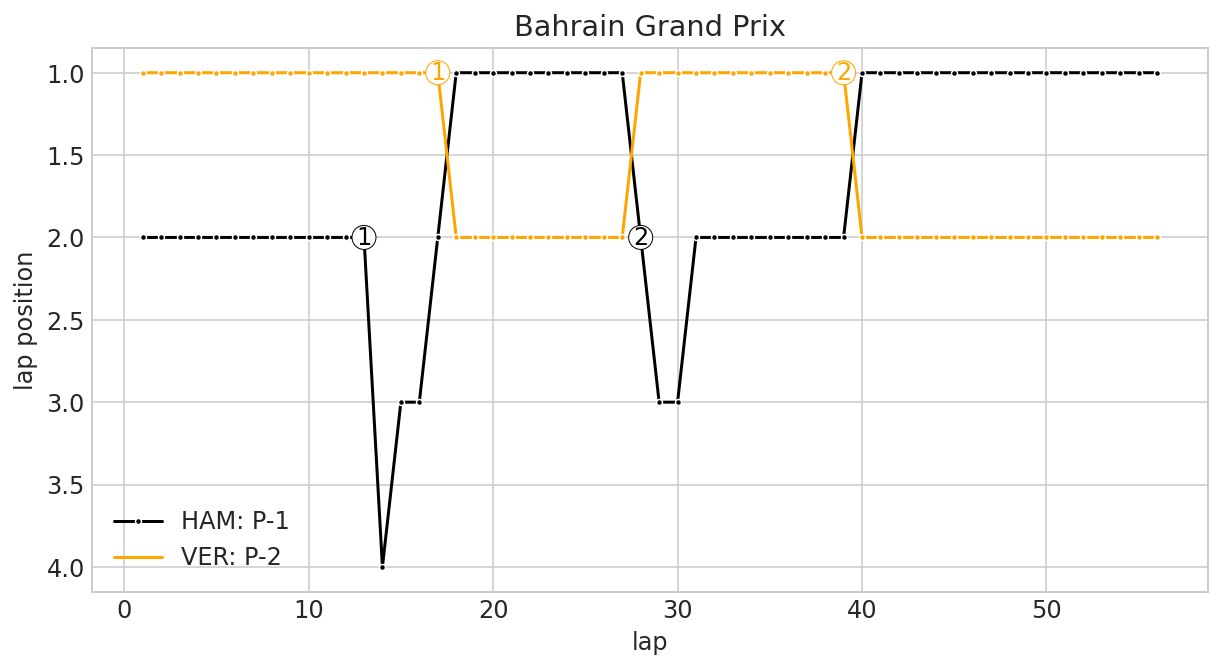

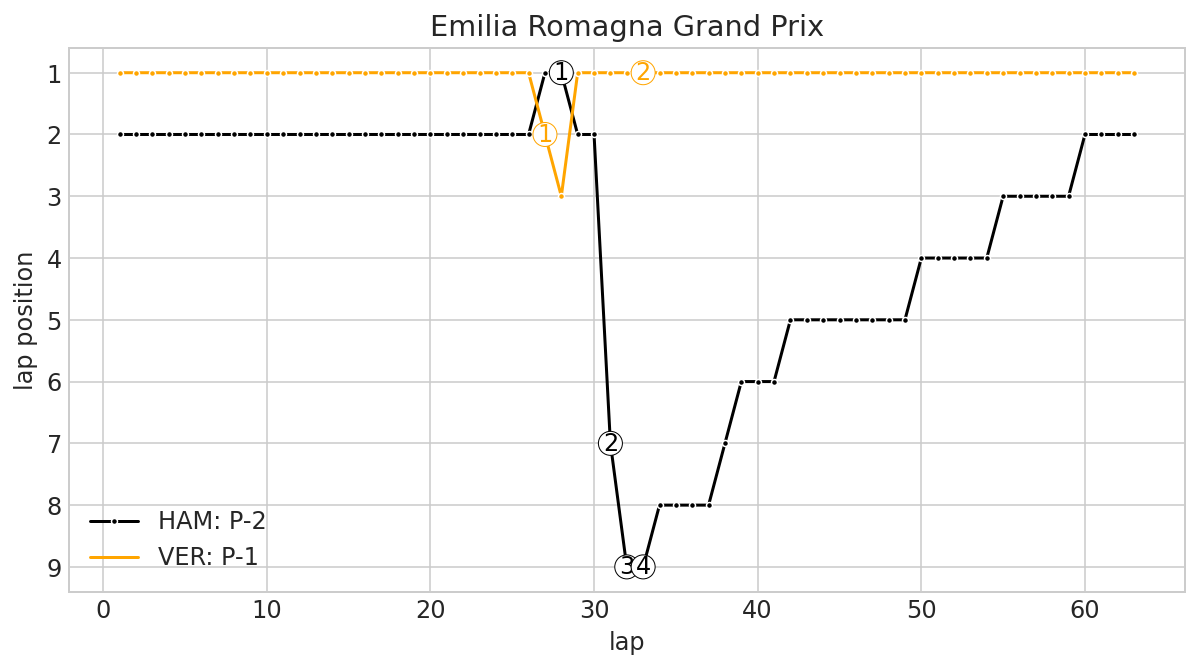

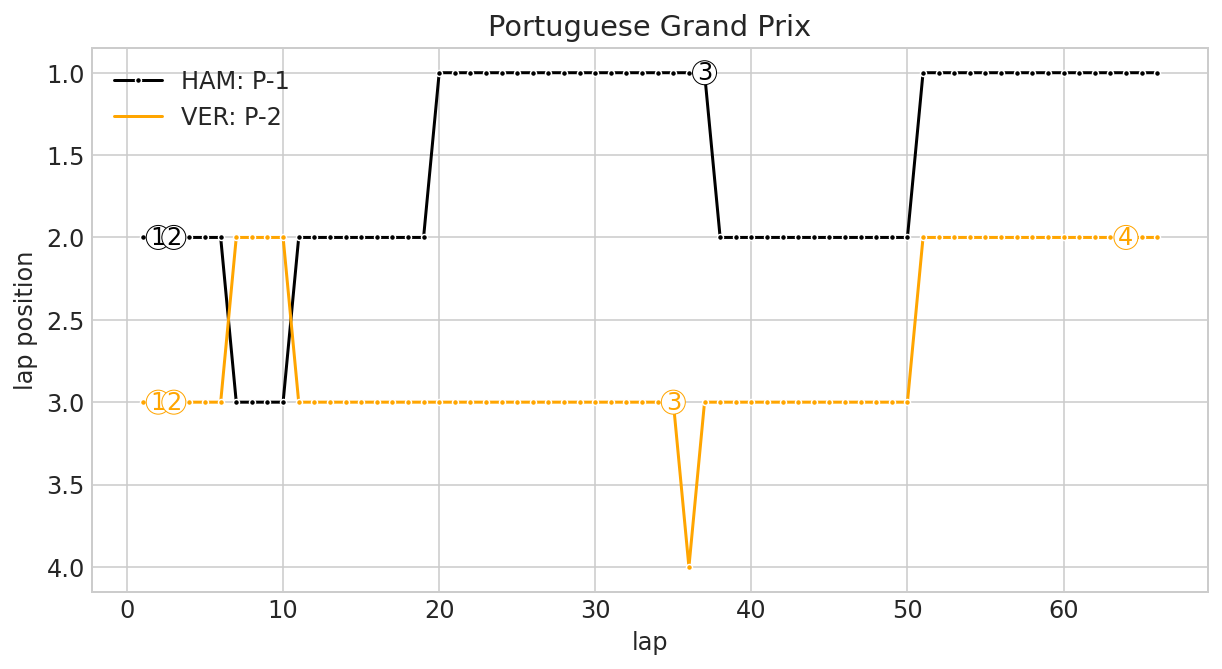

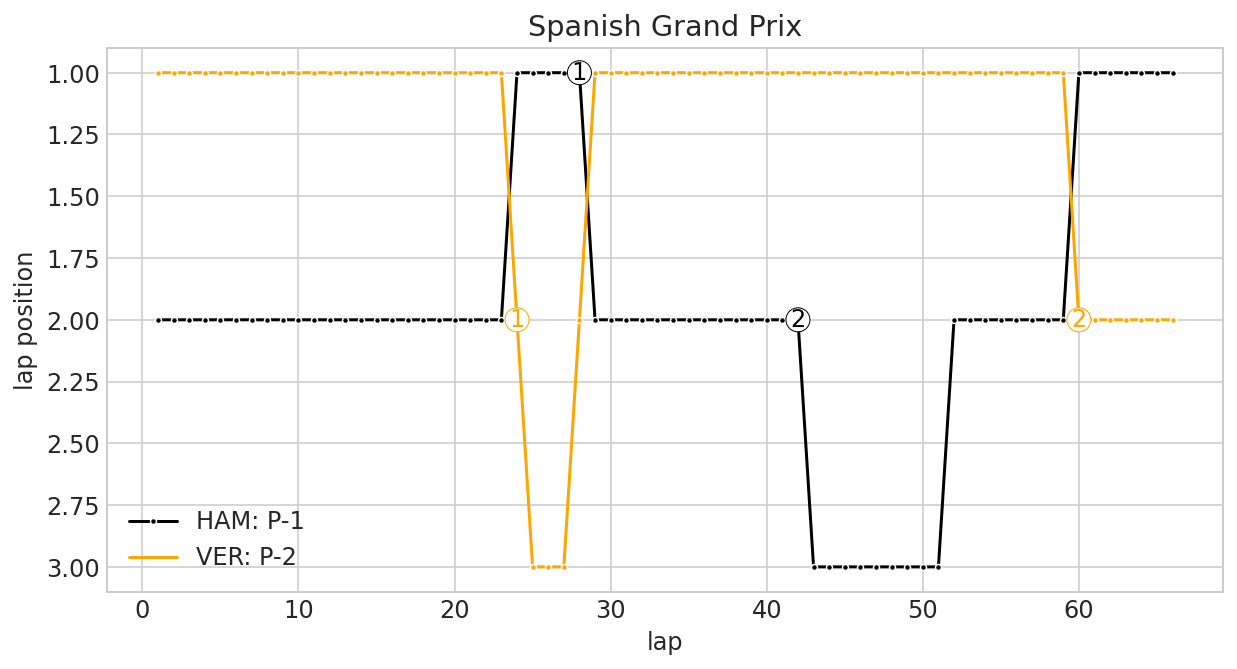

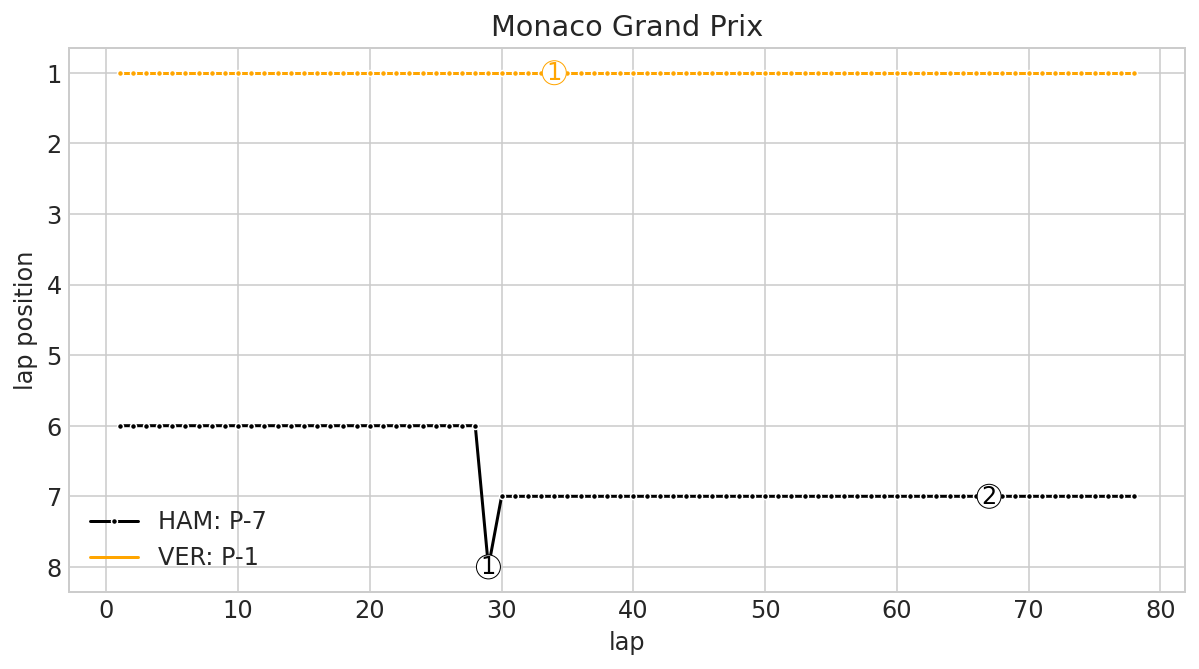

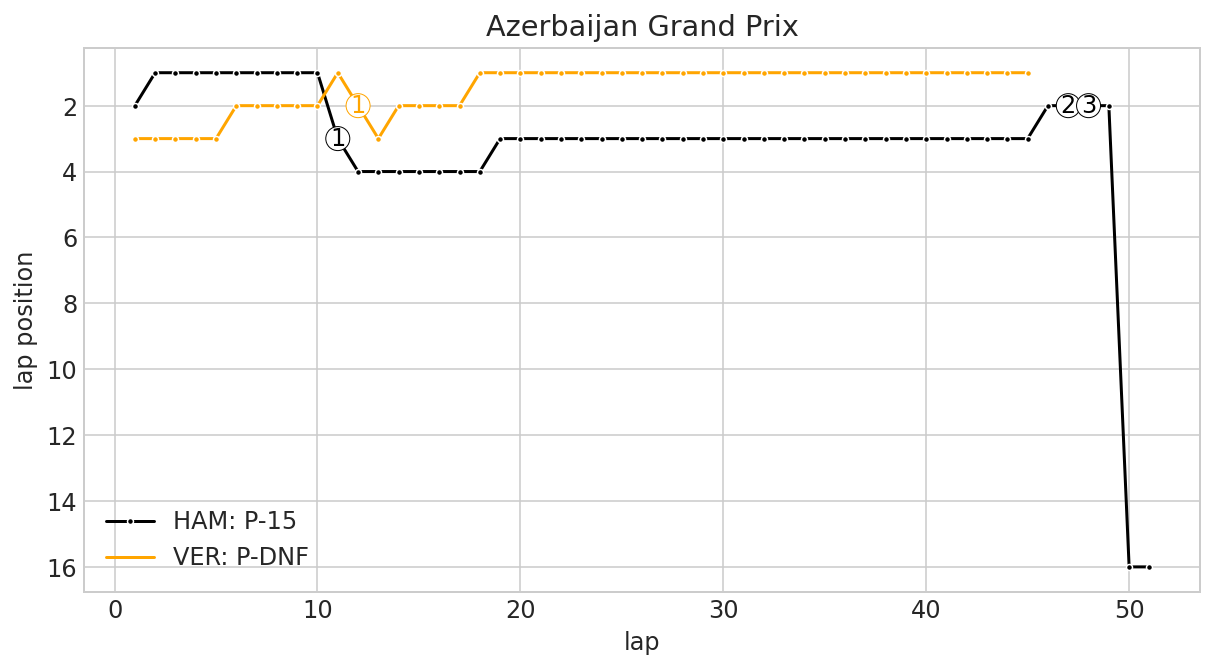

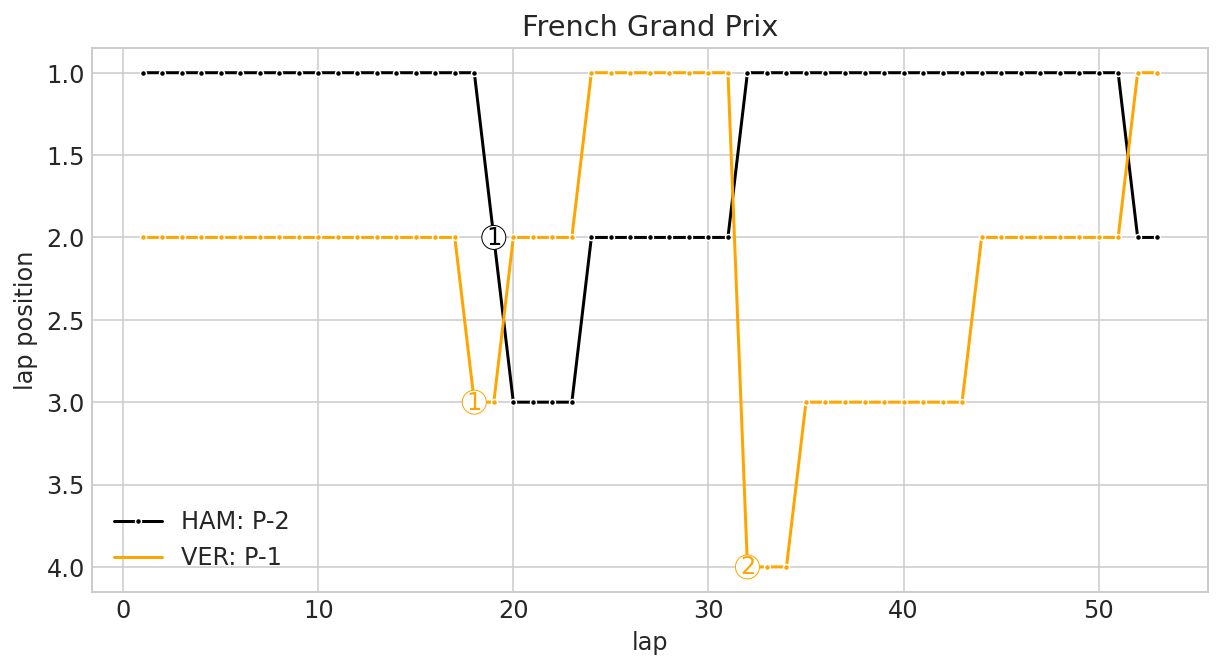

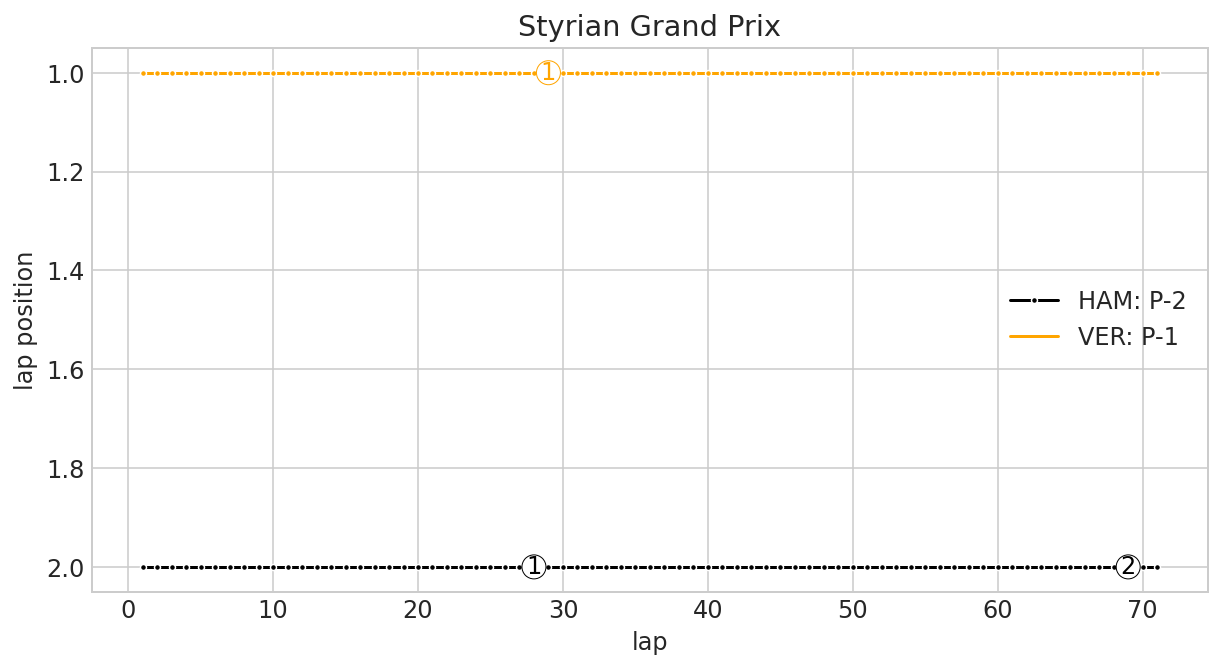

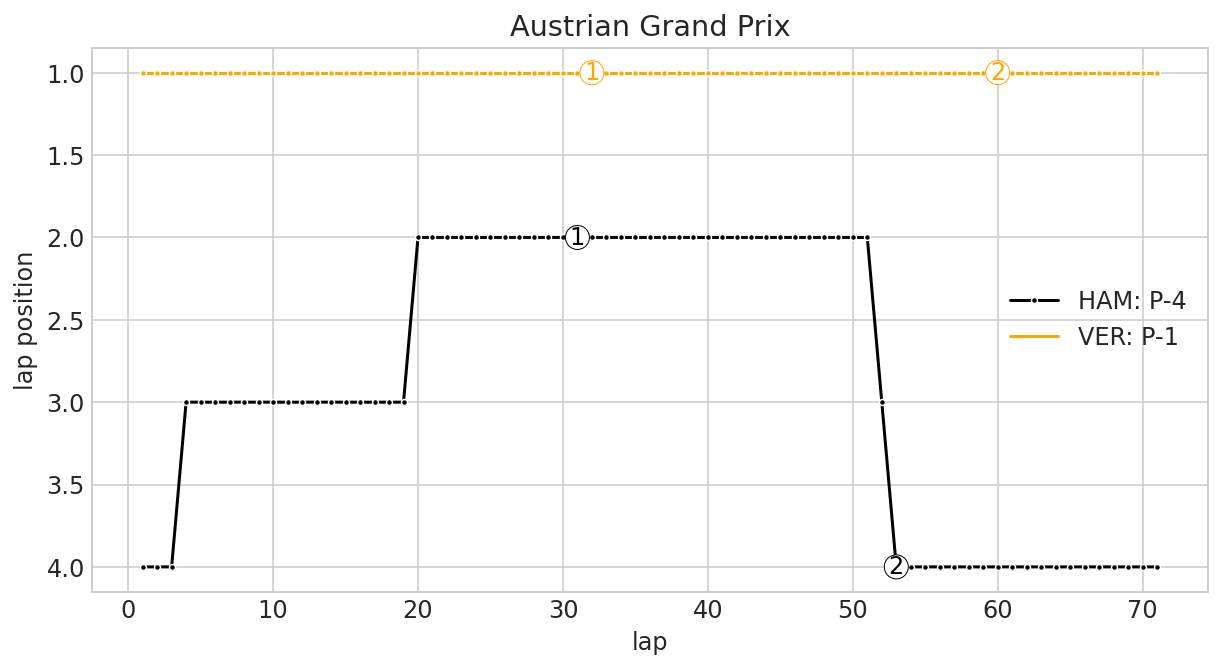

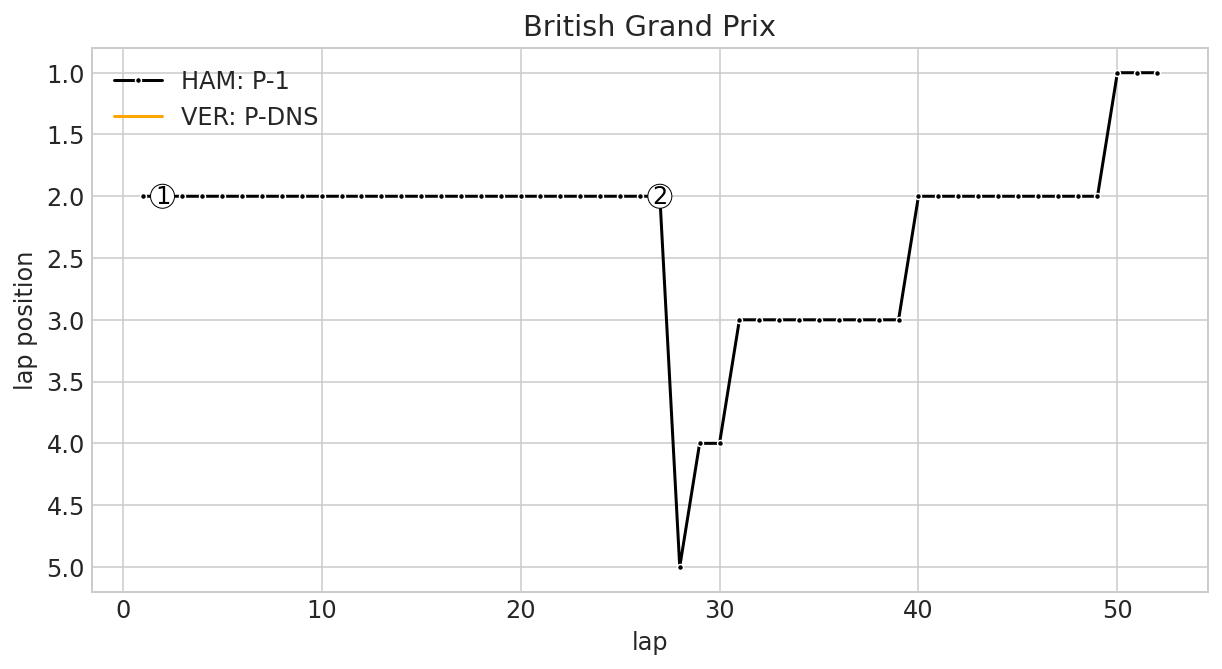

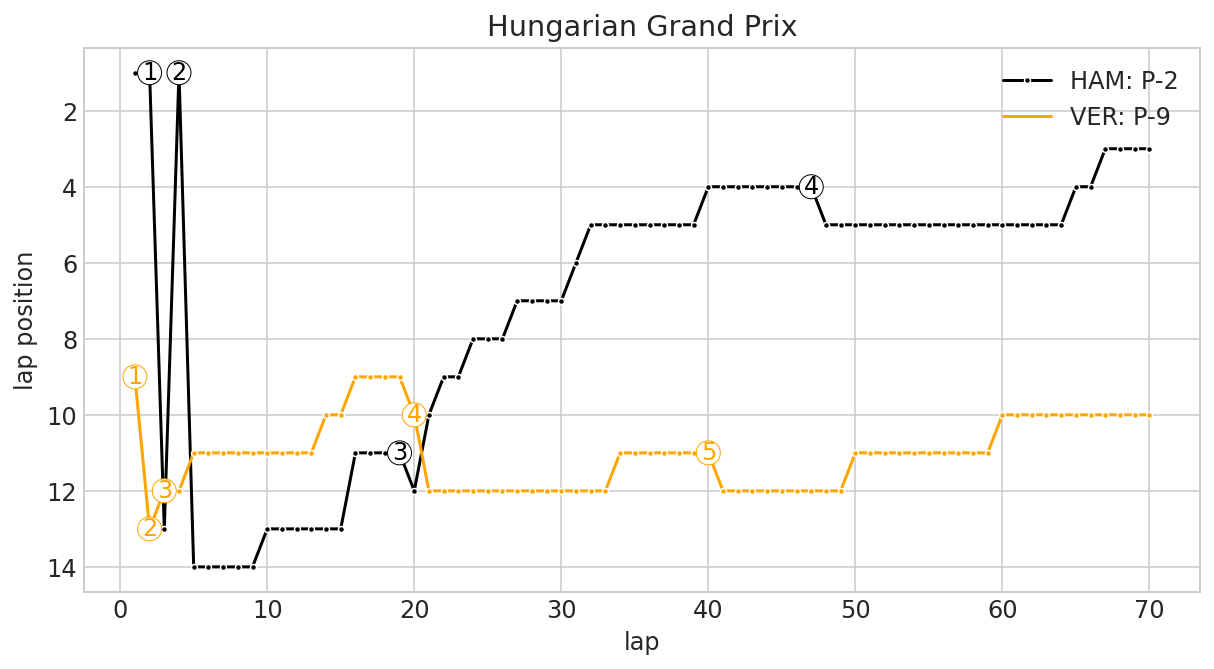

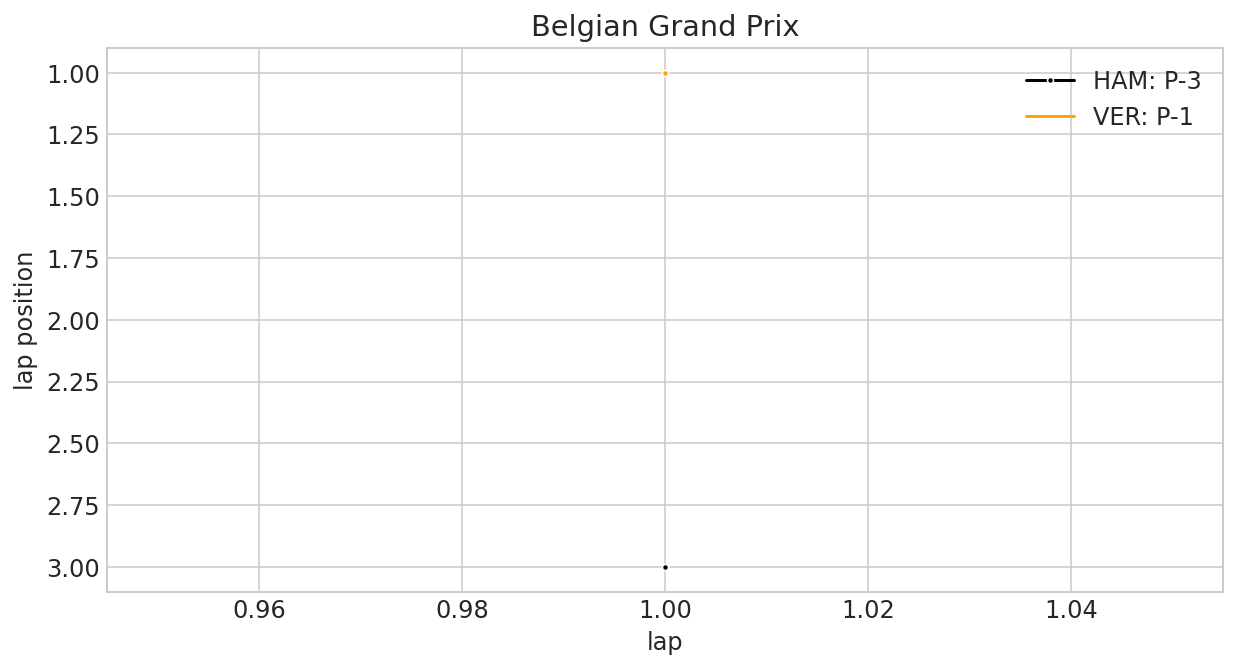

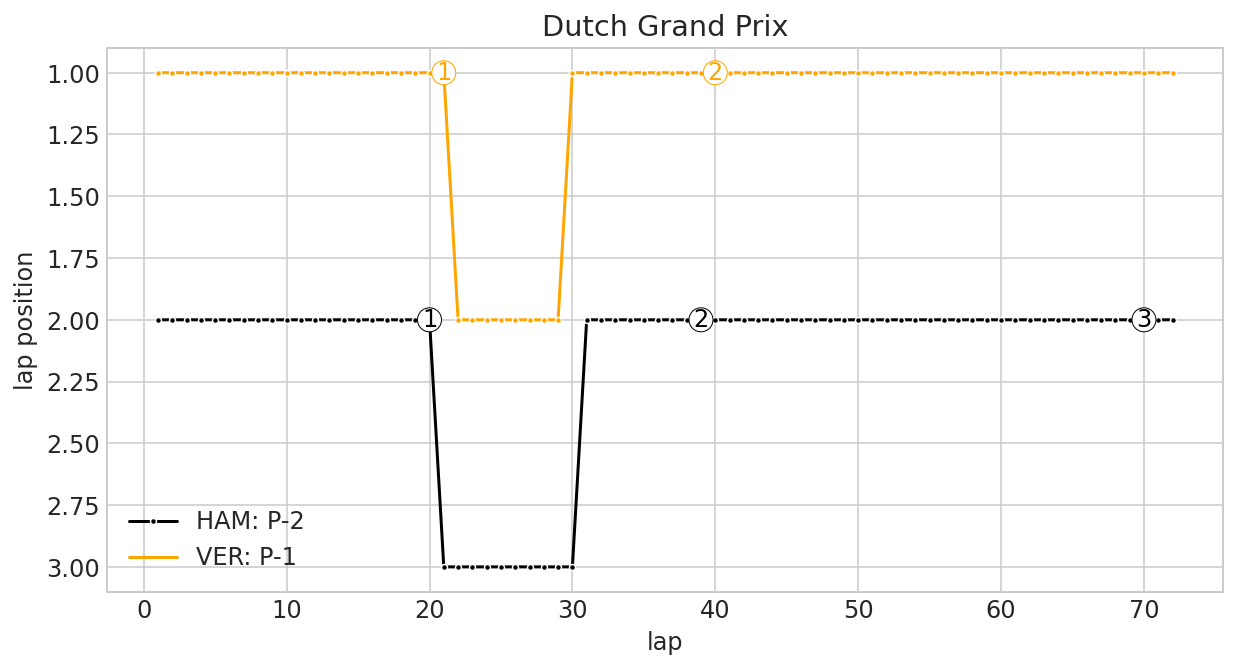

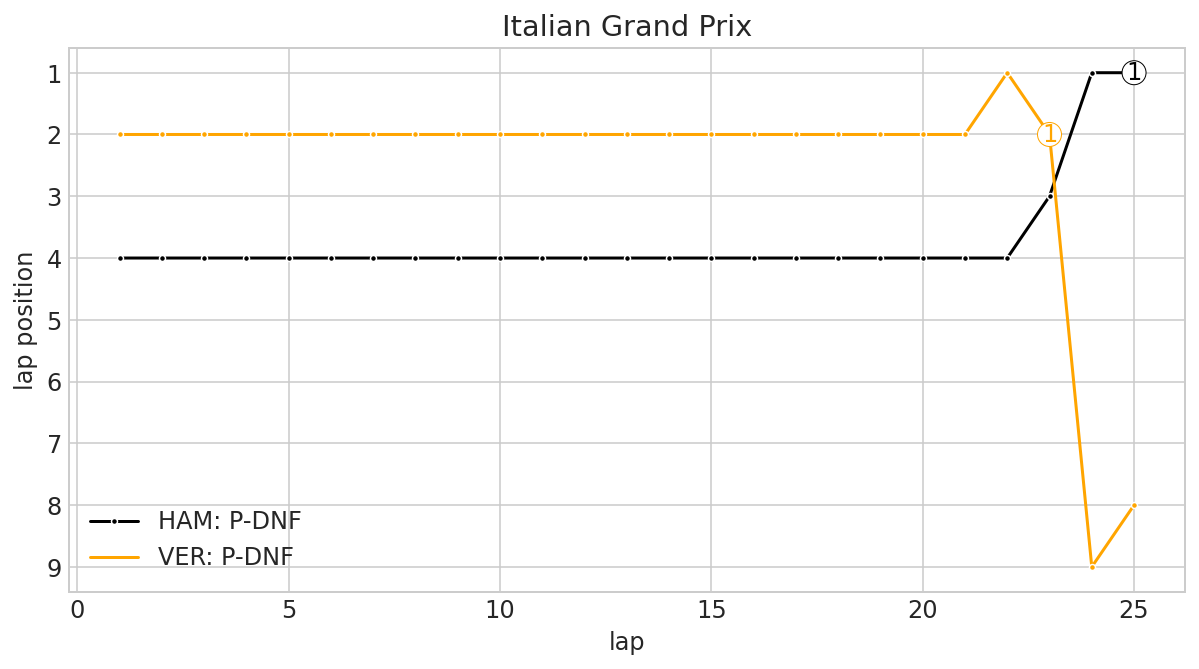

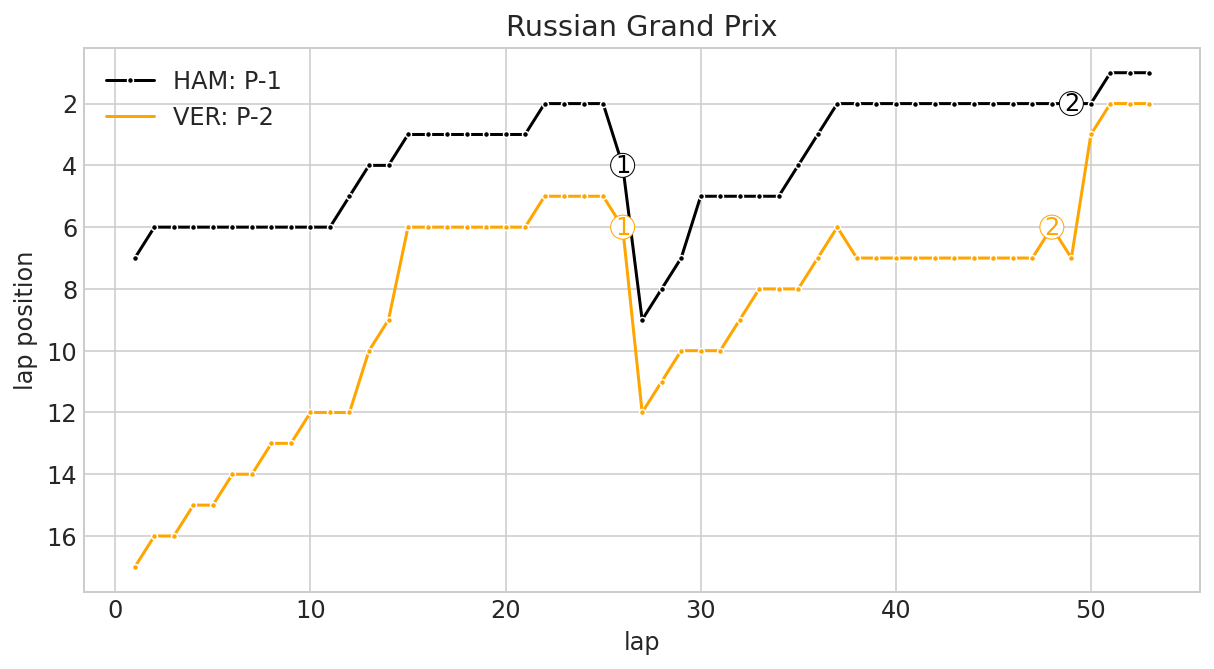

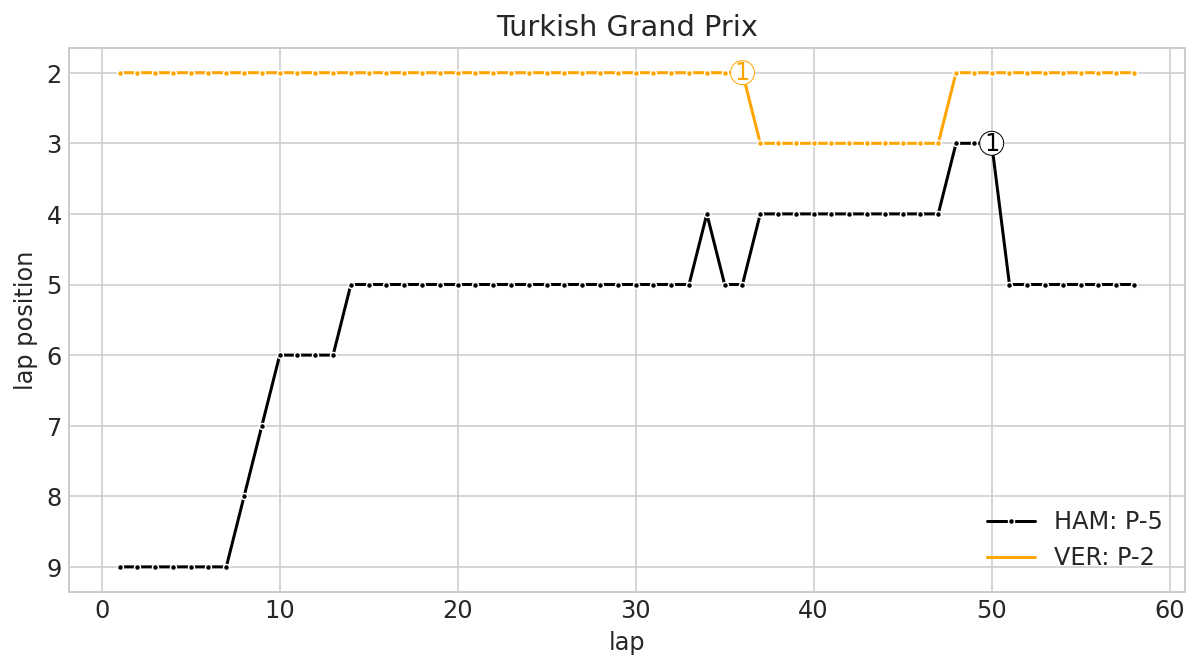

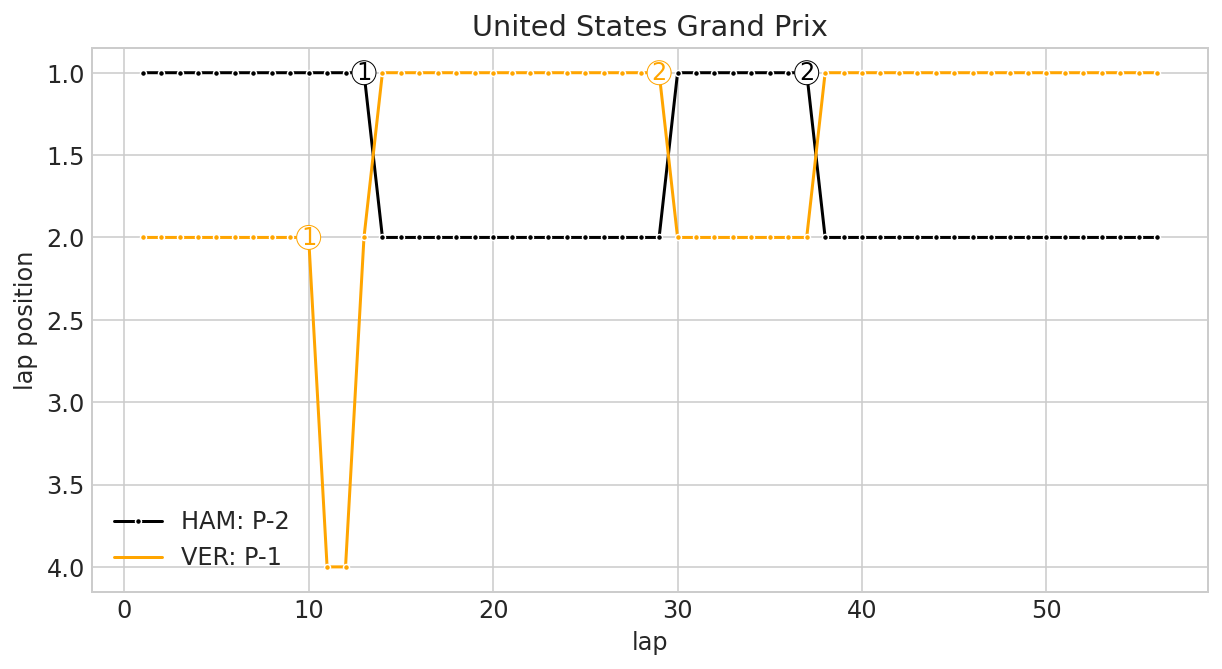

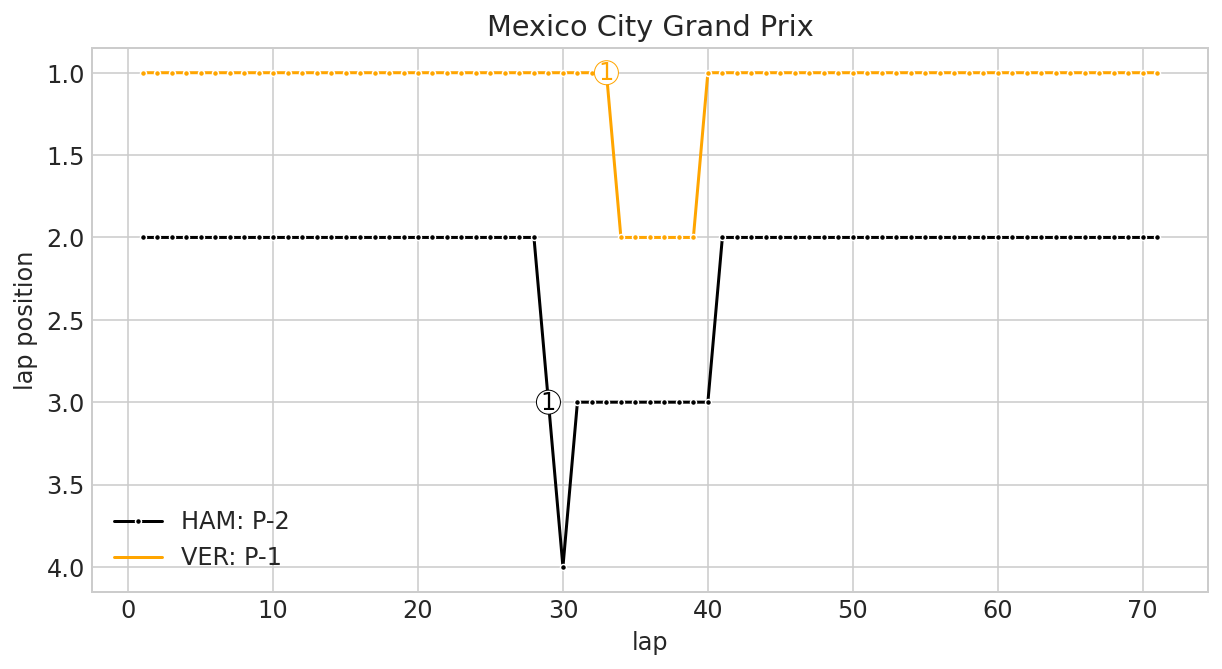

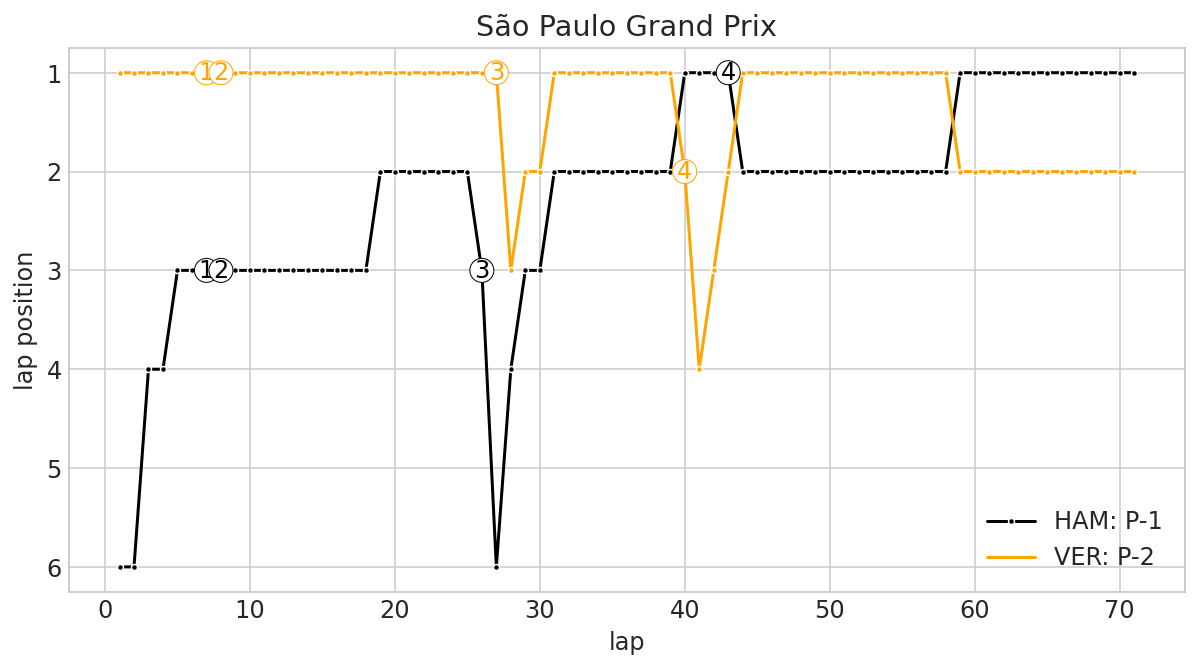

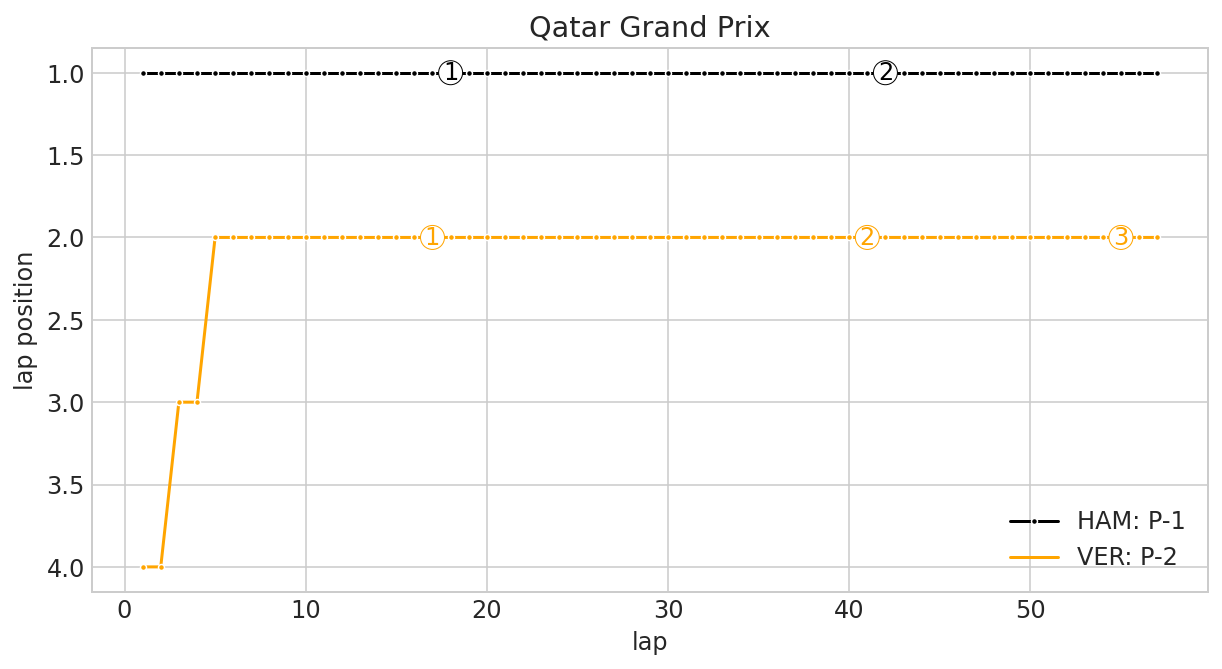

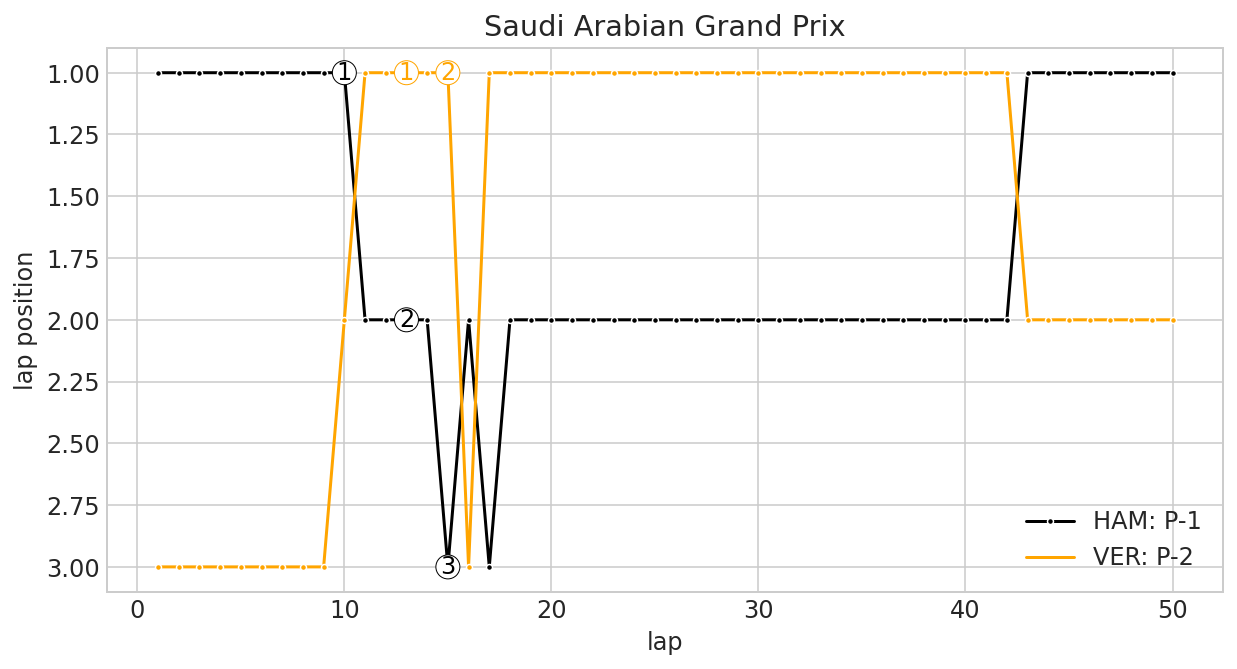

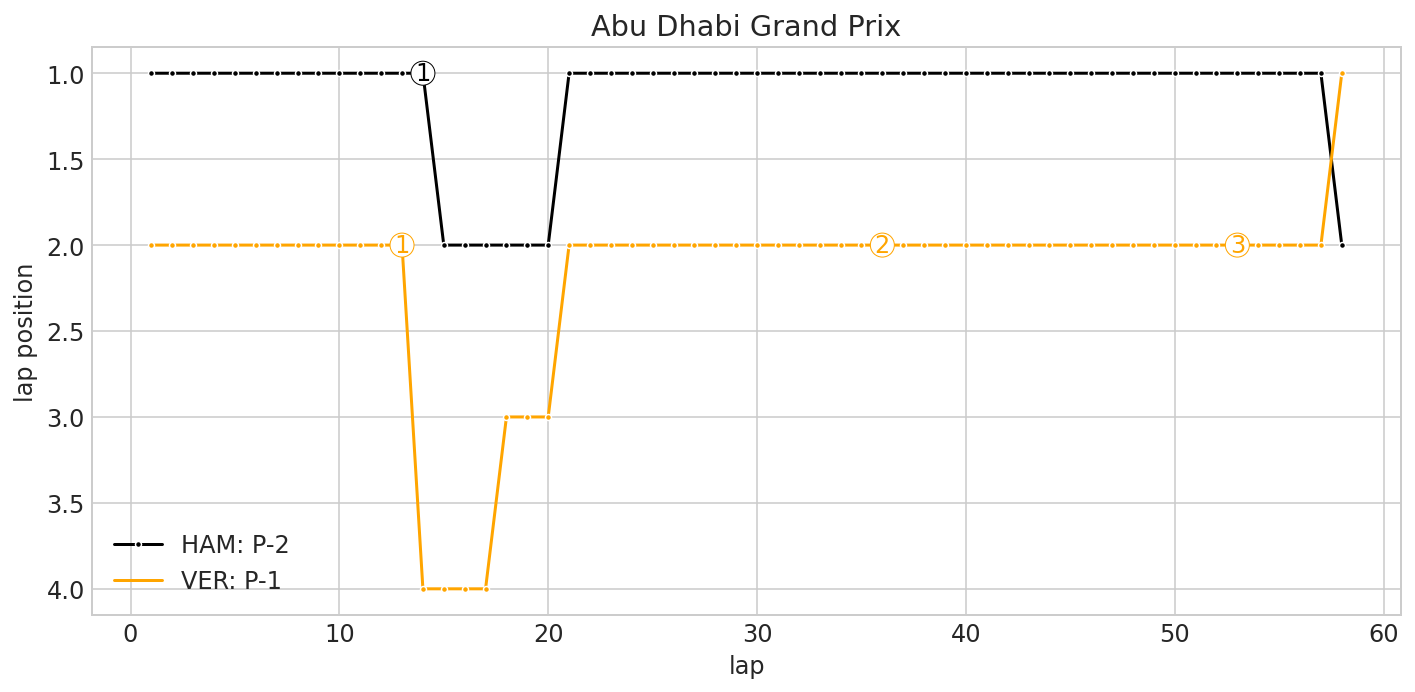

In [17]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=10,5 
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.labelsize']=12
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12

plt.figure(figsize=(10, 100))
for i, f in tqdm(enumerate(df_laps['name'].unique())):
    try:
        HAM_pos = list(set(df_laps[(df_laps['name']==f)&(df_laps['code']=='HAM')]['position']))[0]
        if HAM_pos == r'\N':
            HAM_pos = 'DNF'
    except:
        HAM_pos = 'DNS'
    try:    
        VER_pos = list(set(df_laps[(df_laps['name']==f)&(df_laps['code']=='VER')]['position']))[0]
        if VER_pos == r'\N':
            VER_pos = 'DNF'
    except:
        VER_pos = 'DNS'
    fig,ax = plt.subplots(1,1)
    plt.title(f)
    sns.lineplot(data=df_laps[(df_laps['name']==f)&(df_laps['code']=='HAM')],
                 x='lap', 
                 y='lap position',
                 hue='code',
                 palette=['black'],
                 marker='.',
                 ax=ax
                )
    HAM_stops = df_laps[(df_laps['name']==f)&(df_laps['code']=='HAM')]
    for j,label in enumerate(HAM_stops['stop']):
        plt.annotate(label, (HAM_stops['lap'].iloc[j], 
                             HAM_stops['lap position'].iloc[j]
                            ), 
                     color = 'black',
                     bbox=dict(boxstyle="circle,pad=0", fc="white", ec="black", lw=0.5),
                     ha="center", va="center",
                    )
    
    sns.lineplot(data=df_laps[(df_laps['name']==f)&(df_laps['code']=='VER')],
                 x='lap', 
                 y='lap position',
                 hue='code',
                 ax=ax,
                 palette = ['orange'],
                 marker='.',
                )
    
    VER_stops = df_laps[(df_laps['name']==f)&(df_laps['code']=='VER')]
    for j,label in enumerate(VER_stops['stop']):
        plt.annotate(label, (VER_stops['lap'].iloc[j], 
                             VER_stops['lap position'].iloc[j]
                            ),
                     color='orange',
                     bbox=dict(boxstyle="circle,pad=0", fc="white", ec="orange", lw=0.5),
                     ha="center", va="center",
                    )
    
    if ax.get_legend_handles_labels()[1][0]=='HAM':
        plt.legend(['HAM: P-'+str(HAM_pos), 'VER: P-'+str(VER_pos)])
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('black')
        leg.legendHandles[1].set_color('orange')
    elif ax.get_legend_handles_labels()[1][0]=='VER':
        plt.legend(['VER: P-'+str(VER_pos), 'HAM: P-'+str(HAM_pos)])
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('orange')
        leg.legendHandles[1].set_color('black')
    plt.ylim(reversed(plt.ylim()))    
    # 
    # VER_stop = df_laps[(df_laps['name']==f)&(df_laps['code']=='VER')]
    # for j,label in enumerate(df_laps['stop']):
    #     plt.annotate(label, (df_laps['lap'][j], 
    #                          df_laps['seconds'][j]
    #                         ) 
    #                 )
        
plt.tight_layout()
plt.show()

<a id='3'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Race Results</b>

The race results and the accumulation of points throughout the season also tell us the tale of how close the championship was. The charts show us the race positions per race, as well as a chart with the championship points througout the season.

In [18]:
df_results = df_results.merge(df_drivers[['driverId','code','driverRef']],how='left',on='driverId')
df_results = df_results.merge(df_races[['raceId','name','date','year']],how='left',on='raceId')

In [19]:
df_results.drop_duplicates(inplace=True)

In [20]:
df_results[df_results['position']==r'\N']=0
df_results['position'] = df_results['position'].astype(int)

In [21]:
df_results = df_results[(df_results['year']==2021)&((df_results['code']=='VER')|(df_results['code']=='HAM'))]

In [22]:
df_results.head()

resultId  raceId  driverId  constructorId number  grid  position positionText  positionOrder  points  laps         time milliseconds fastestLap rank fastestLapTime fastestLapSpeed  statusId code       driverRef                       name        date  year
24960     24966    1052         1            131     44     2         1            1              1    25.0    56  1:32:03.897      5523897         44    4       1:34.015         207.235         1  HAM        hamilton         Bahrain Grand Prix  2021-03-28  2021
24961     24967    1052       830              9     33     1         2            2              2    18.0    56       +0.745      5524642         41    2       1:33.228         208.984         1  VER  max_verstappen         Bahrain Grand Prix  2021-03-28  2021
24980     24986    1053       830              9     33     3         1            1              1    25.0    63  2:02:34.598      7354598         60    2       1:17.524         227.960         1  VER  max_verstappen  Emilia Romagna Grand Prix  2021-04-18  2021
24981     24987    1053         1            131     44     1         2            2              2    19.0    63      +22.000      7376598         60    1       1:16.702         230.403         1  HAM        hamilton  Emilia Romagna Grand Prix  2021-04-18  2021
25000     25006    1054         1            131     44     2         1            1              1    25.0    66  1:34:31.421      5671421         47    4       1:20.933         206.971         1  HAM        hamilton      Portuguese Grand Prix  2021-05-02  2021

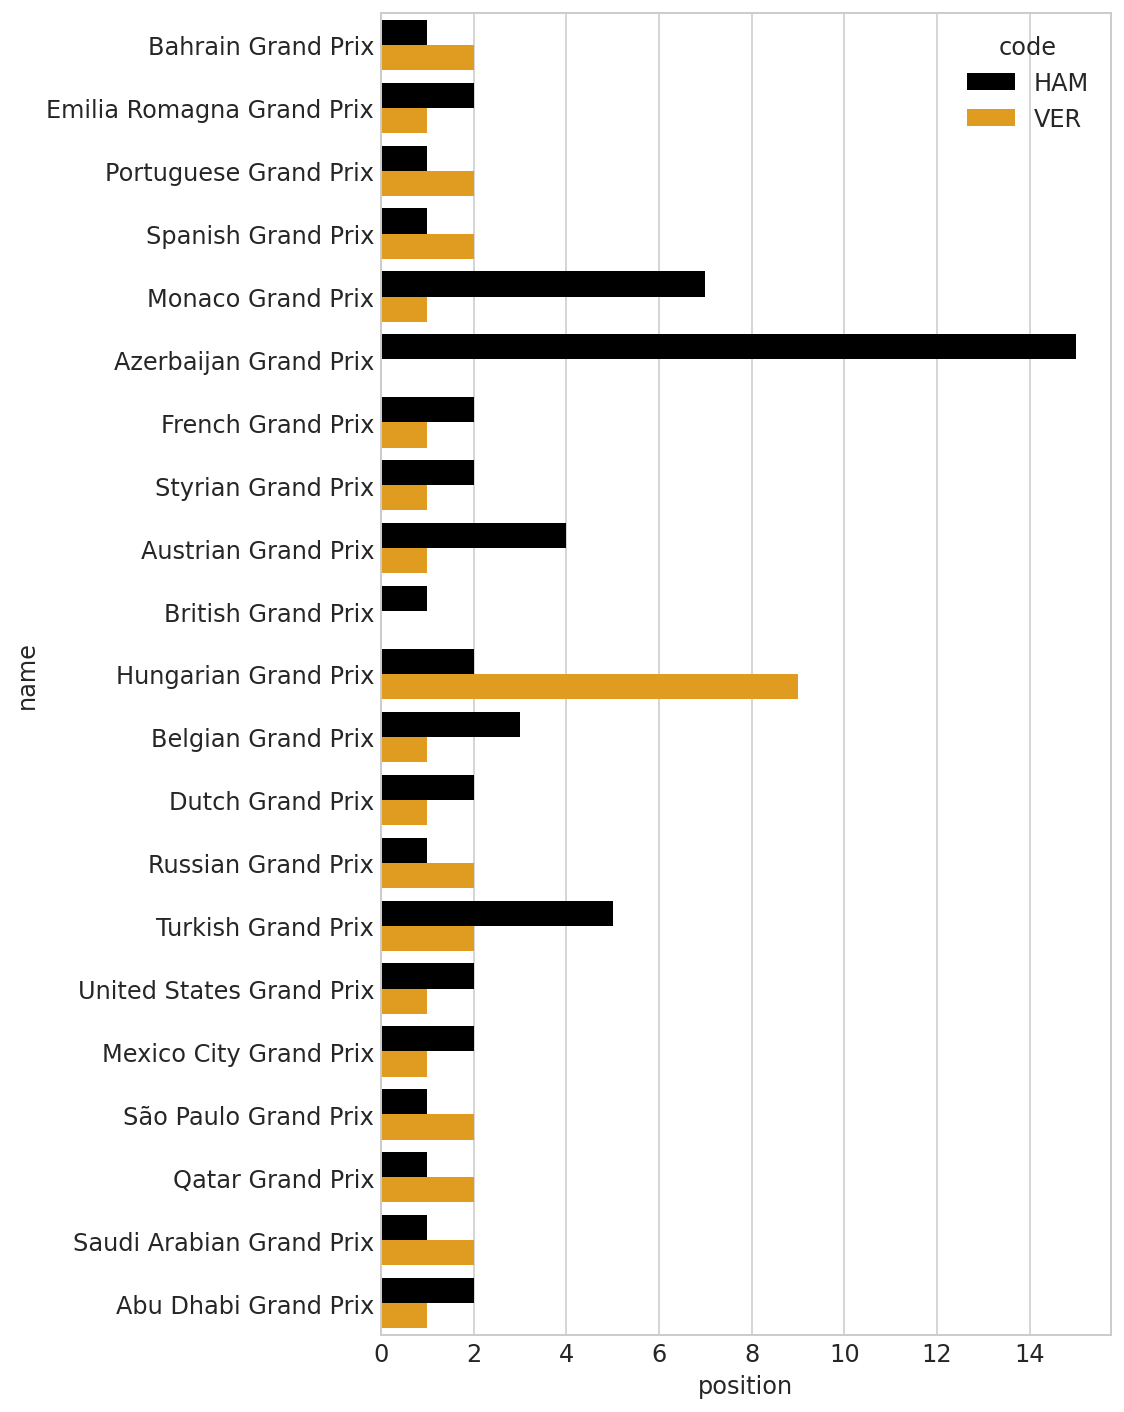

In [23]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=8,10 
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.labelsize']=12
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12
sns.barplot(data=df_results,x='position', y='name',hue='code',palette=['black','orange'])
plt.tight_layout()
plt.show()

In [24]:
df_driver_standings = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv')
df_driver_standings.head()

driverStandingsId  raceId  driverId  points  position positionText  wins
0                  1      18         1    10.0         1            1     1
1                  2      18         2     8.0         2            2     0
2                  3      18         3     6.0         3            3     0
3                  4      18         4     5.0         4            4     0
4                  5      18         5     4.0         5            5     0

In [25]:
df_driver_standings = df_driver_standings.merge(df_drivers[['driverId','code','driverRef']],how='left',on='driverId')
df_driver_standings = df_driver_standings.merge(df_races[['raceId','name','date','year']],how='left',on='raceId')

In [26]:
df_driver_standings.head()

driverStandingsId  raceId  driverId  points  position positionText  wins code   driverRef                   name        date  year
0                  1      18         1    10.0         1            1     1  HAM    hamilton  Australian Grand Prix  2008-03-16  2008
1                  2      18         2     8.0         2            2     0  HEI    heidfeld  Australian Grand Prix  2008-03-16  2008
2                  3      18         3     6.0         3            3     0  ROS     rosberg  Australian Grand Prix  2008-03-16  2008
3                  4      18         4     5.0         4            4     0  ALO      alonso  Australian Grand Prix  2008-03-16  2008
4                  5      18         5     4.0         5            5     0  KOV  kovalainen  Australian Grand Prix  2008-03-16  2008

In [27]:
df_driver_standings = df_driver_standings[(df_driver_standings['year']==2021)&((df_driver_standings['code']=='VER')|(df_driver_standings['code']=='HAM'))]
df_driver_standings.sort_values(['date'],inplace=True)

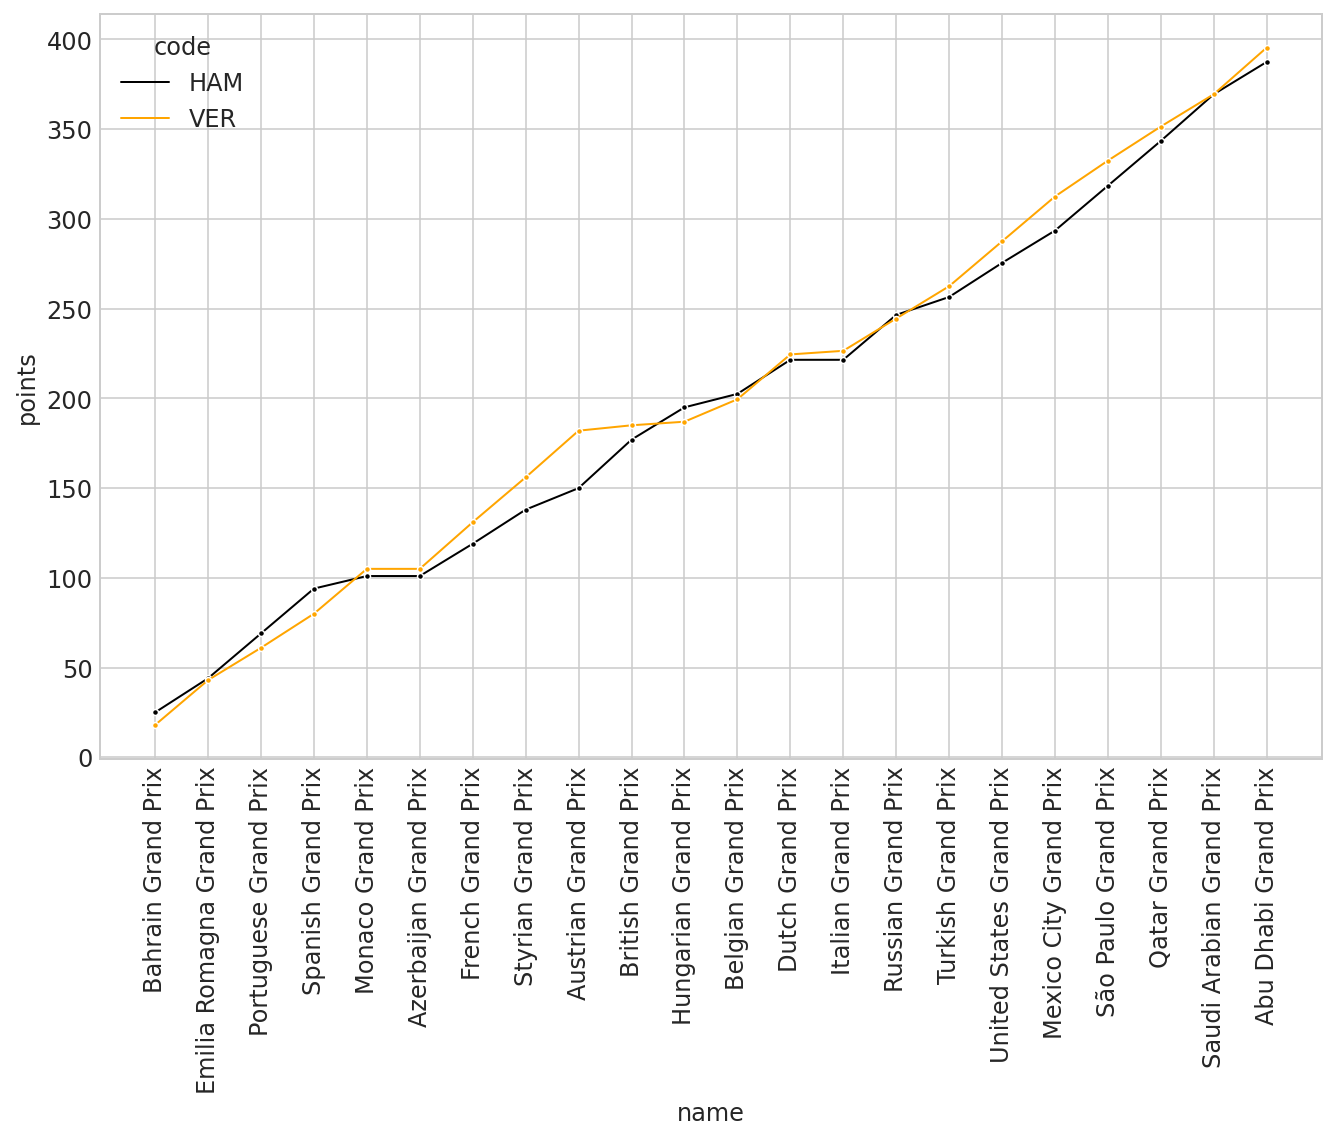

In [28]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=10,6 
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.labelsize']=12
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12
sns.lineplot(data=df_driver_standings,x='name', y='points',hue='code',marker='.',palette=['black','orange'])
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

<a id='4'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Pitstop Analysis</b>

The pitstops are crucial in gaining (or losing) time in the race. This analysis compares the pitstops of the champions. It seems on average that Hamilton had shorter durations on the pitstops than Verstappen (by about 0.5 seconds).   

In [29]:
df_pitstops = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv')
df_pitstops = df_pitstops.merge(df_drivers[['driverId','code','driverRef']],how='left',on='driverId')
df_pitstops = df_pitstops.merge(df_races[['raceId','name','date','year']],how='left',on='raceId')
df_pitstops = df_pitstops[(df_pitstops['year']==2021)&((df_pitstops['code']=='VER')|(df_pitstops['code']=='HAM'))]
df_pitstops['duration']=df_pitstops['milliseconds']/1000
# df_pitstops.head()

In [30]:
# average duration of a pitstop - I've taken out the long pitstops as these are anomalies
df_pitstops[df_pitstops['duration']<40].groupby(['code']).mean()['duration']

code
HAM    23.391359
VER    23.907795
Name: duration, dtype: float64

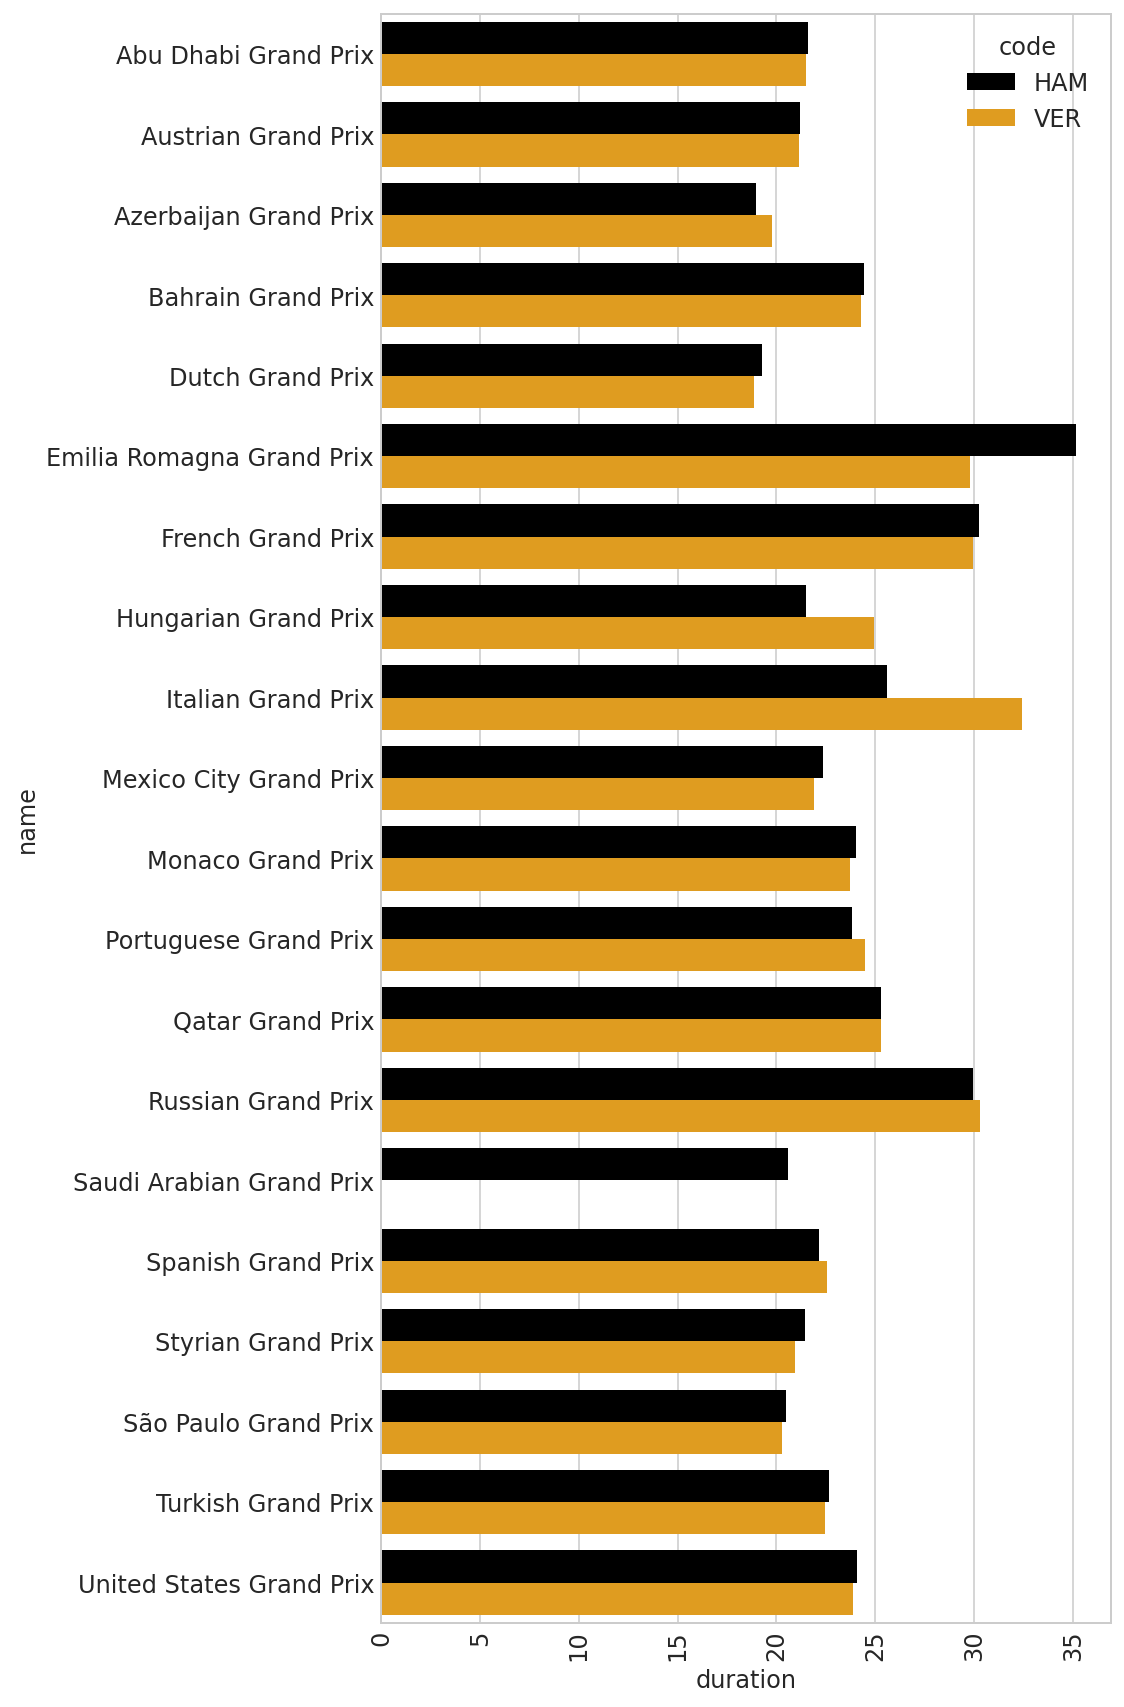

In [31]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=8,12
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.labelsize']=12
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12
sns.barplot(data=df_pitstops[df_pitstops['duration']<40].groupby(['name','code']).mean().reset_index(),
            y='name', 
            x='duration',
            hue='code',
            palette=['black','orange'])
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

<a id='5'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Conversions</b>

In [32]:
df_qualifying = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv')
df_qualifying = df_qualifying.merge(df_drivers[['driverId','code','driverRef']],how='left',on='driverId')
df_qualifying = df_qualifying.merge(df_races[['raceId','name','date','year']],how='left',on='raceId')
df_qualifying = df_qualifying[(df_qualifying['year']==2021)&((df_qualifying['code']=='VER')|(df_qualifying['code']=='HAM'))]

In [33]:
df_conversions = df_qualifying.copy()
df_conversions.rename(columns={'position':'start position'},inplace=True)
df_first_lap = df_laps[df_laps['lap']==1]
df_conversions = df_conversions.merge(df_first_lap[['raceId','driverId','lap position']],on=['raceId','driverId'],how='left')
df_conversions.rename(columns={'lap position':'lap 1 position'}, inplace=True)
df_conversions = df_conversions.merge(df_results[['raceId','driverId','position']],on=['raceId','driverId'],how='left')
df_conversions.rename(columns={'position':'final position'},inplace=True)
df_conversions['Start to Lap 1']= -df_conversions['lap 1 position'] + df_conversions['start position']
df_conversions['Qualifying conversion']= -df_conversions['final position'] + df_conversions['start position']
df_conversions['Lap 1 conversion']= -df_conversions['final position'] + df_conversions['lap 1 position']

In [34]:
df_conversions.head()

qualifyId  raceId  driverId  constructorId  number  start position        q1        q2        q3 code       driverRef                       name        date  year  lap 1 position  final position  Start to Lap 1  Qualifying conversion  Lap 1 conversion
0       8735    1052       830              9      33               1  1:30.499  1:30.318  1:28.997  VER  max_verstappen         Bahrain Grand Prix  2021-03-28  2021             1.0             2.0             0.0                   -1.0              -1.0
1       8736    1052         1            131      44               2  1:30.617  1:30.085  1:29.385  HAM        hamilton         Bahrain Grand Prix  2021-03-28  2021             2.0             1.0             0.0                    1.0               1.0
2       8755    1053         1            131      44               1  1:14.823  1:14.817  1:14.411  HAM        hamilton  Emilia Romagna Grand Prix  2021-04-18  2021             2.0             2.0            -1.0                   -1.0               0.0
3       8757    1053       830              9      33               3  1:15.109  1:14.884  1:14.498  VER  max_verstappen  Emilia Romagna Grand Prix  2021-04-18  2021             1.0             1.0             2.0                    2.0               0.0
4       8776    1054         1            131      44               2  1:18.857  1:17.968  1:18.355  HAM        hamilton      Portuguese Grand Prix  2021-05-02  2021             2.0             1.0             0.0                    1.0               1.0

The results below show us that Hamilton typically loses a position on the first lap on average, whereas Verstappen remains relatively unchanged. 
Hamilton finishes a position lower from his qualifying position on average, whereas Verstappen gains a position on average.
Hamilton's position does not change much from the end of his first lap until the end, wheras Verstappen gains a position on average. 

In [35]:
df_conversions.groupby(['code']).mean()[['Start to Lap 1','Qualifying conversion','Lap 1 conversion']]

Start to Lap 1  Qualifying conversion  Lap 1 conversion
code                                                         
HAM        -0.727273              -0.619048          0.047619
VER         0.047619               1.000000          1.000000

The chart below gives us an indication of how well the first lap went. It shows how many places were gained or lost on the first lap. If there is nothing plotted, it means that the position did not change, or that the first lap was not completed.

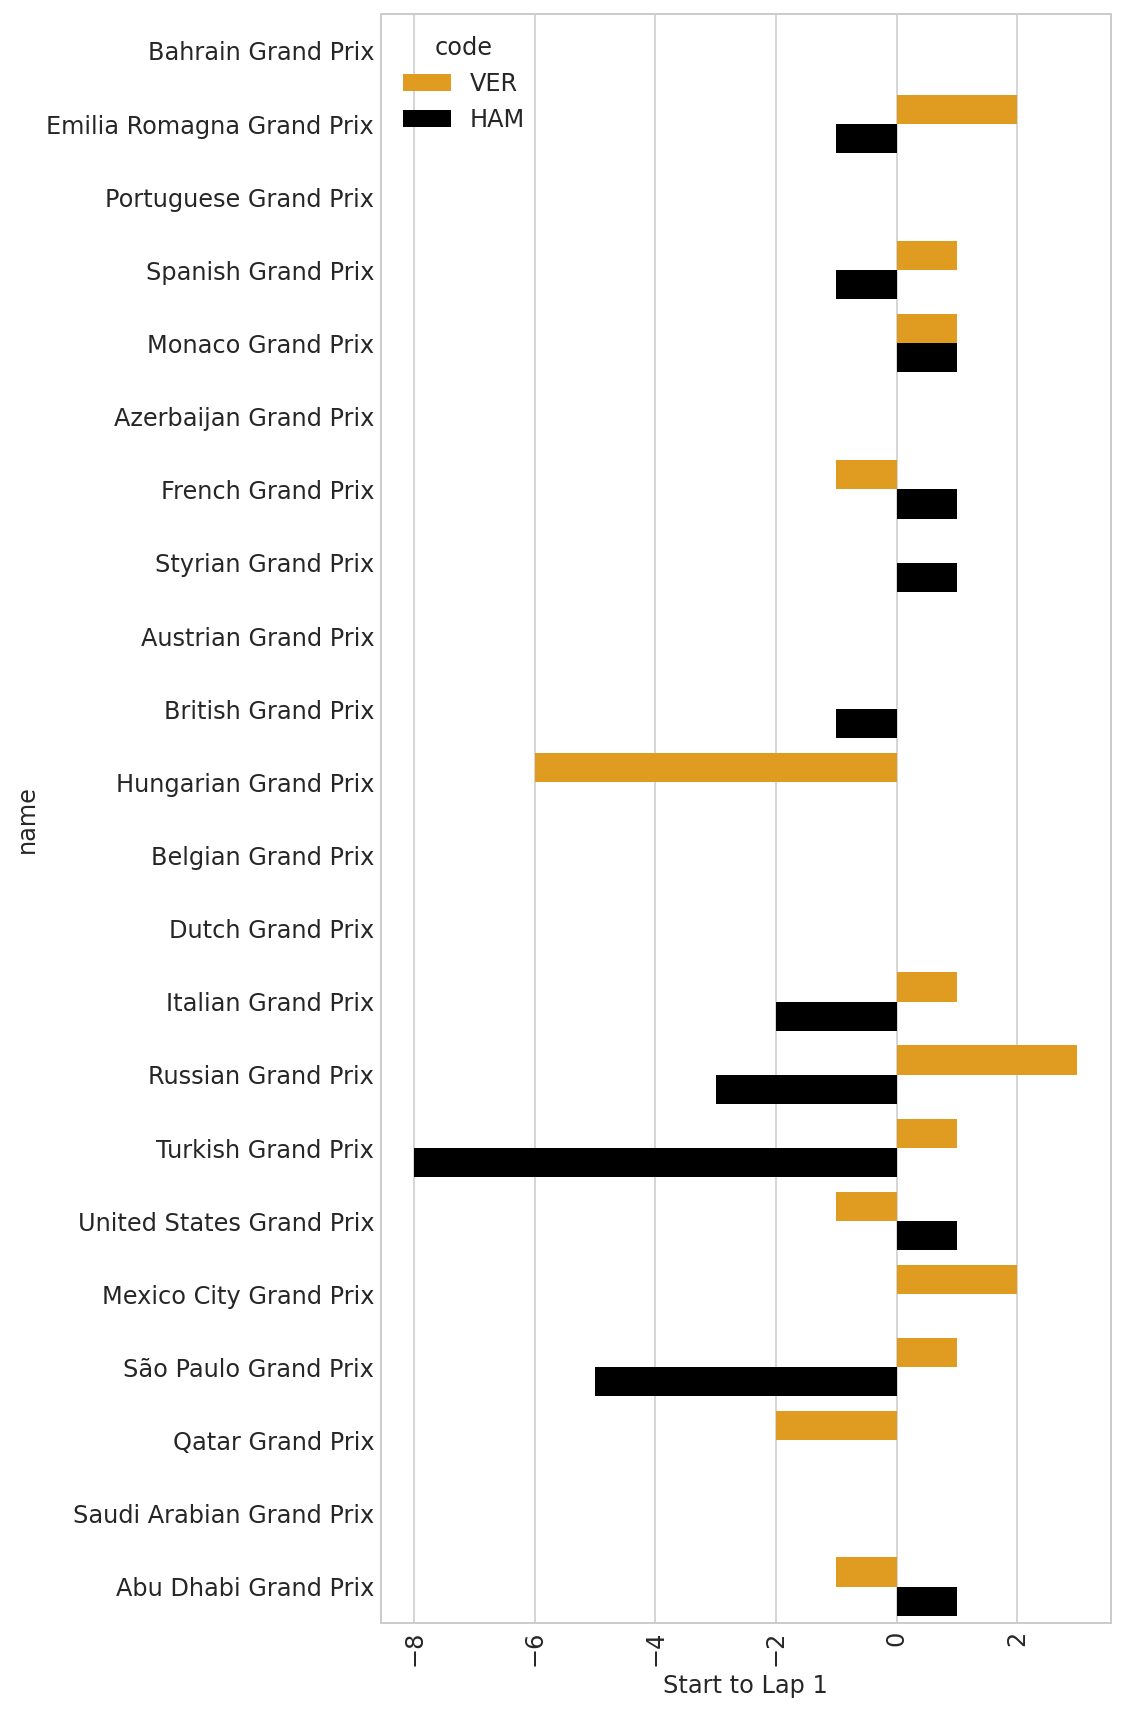

In [36]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=8,12
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.labelsize']=12
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12
sns.barplot(data=df_conversions,
            y='name', 
            x='Start to Lap 1',
            hue='code',
            palette=['orange','black'])
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

The chart below shows how many places were gained or lost from the start of the race until the end. The chart below gives us an indication of how well the first lap went. It shows how many places were gained or lost on the first lap. If there is nothing plotted, it means that the position did not change, or that the race was not completed.

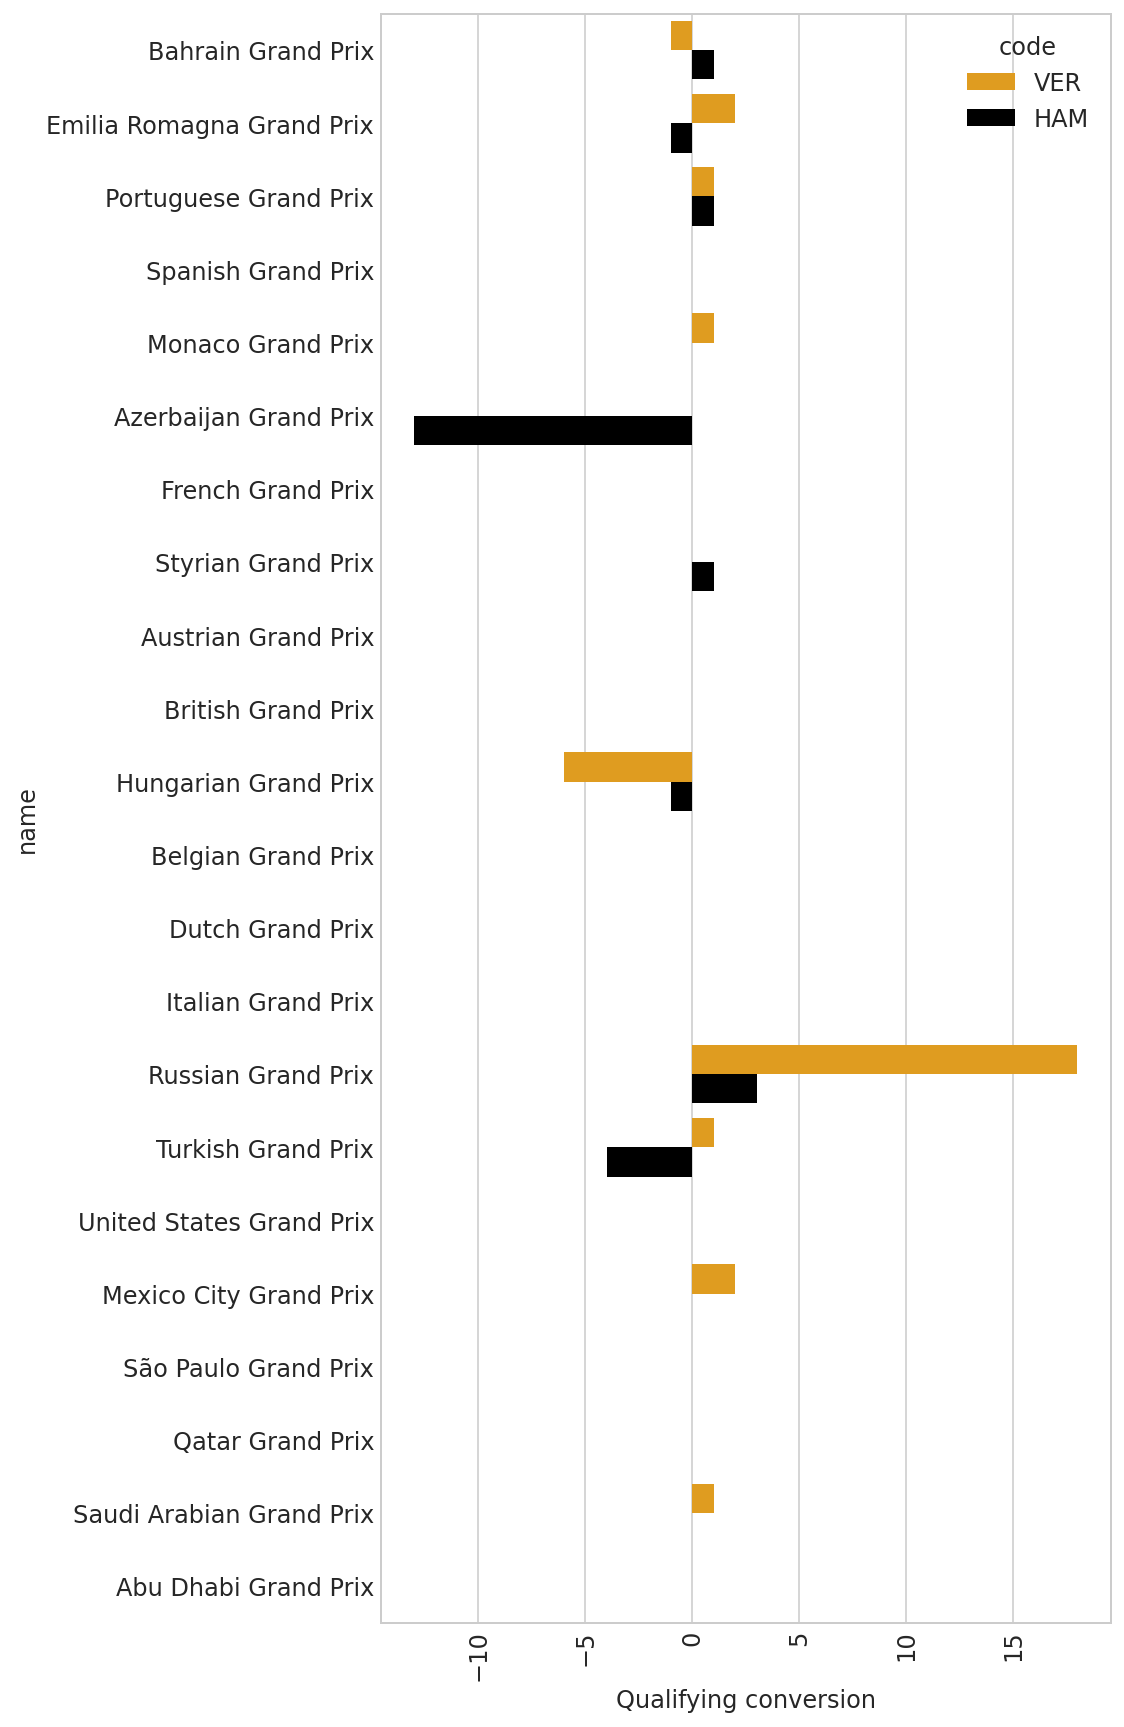

In [37]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=8,12
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.labelsize']=12
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12
sns.barplot(data=df_conversions,
            y='name', 
            x='Qualifying conversion',
            hue='code',
            palette=['orange','black'])
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

The chart below shows how many places were gained or lost from the end of lap 1 until the end. If there is nothing plotted, it means that the position did not change, or that the race was not completed.

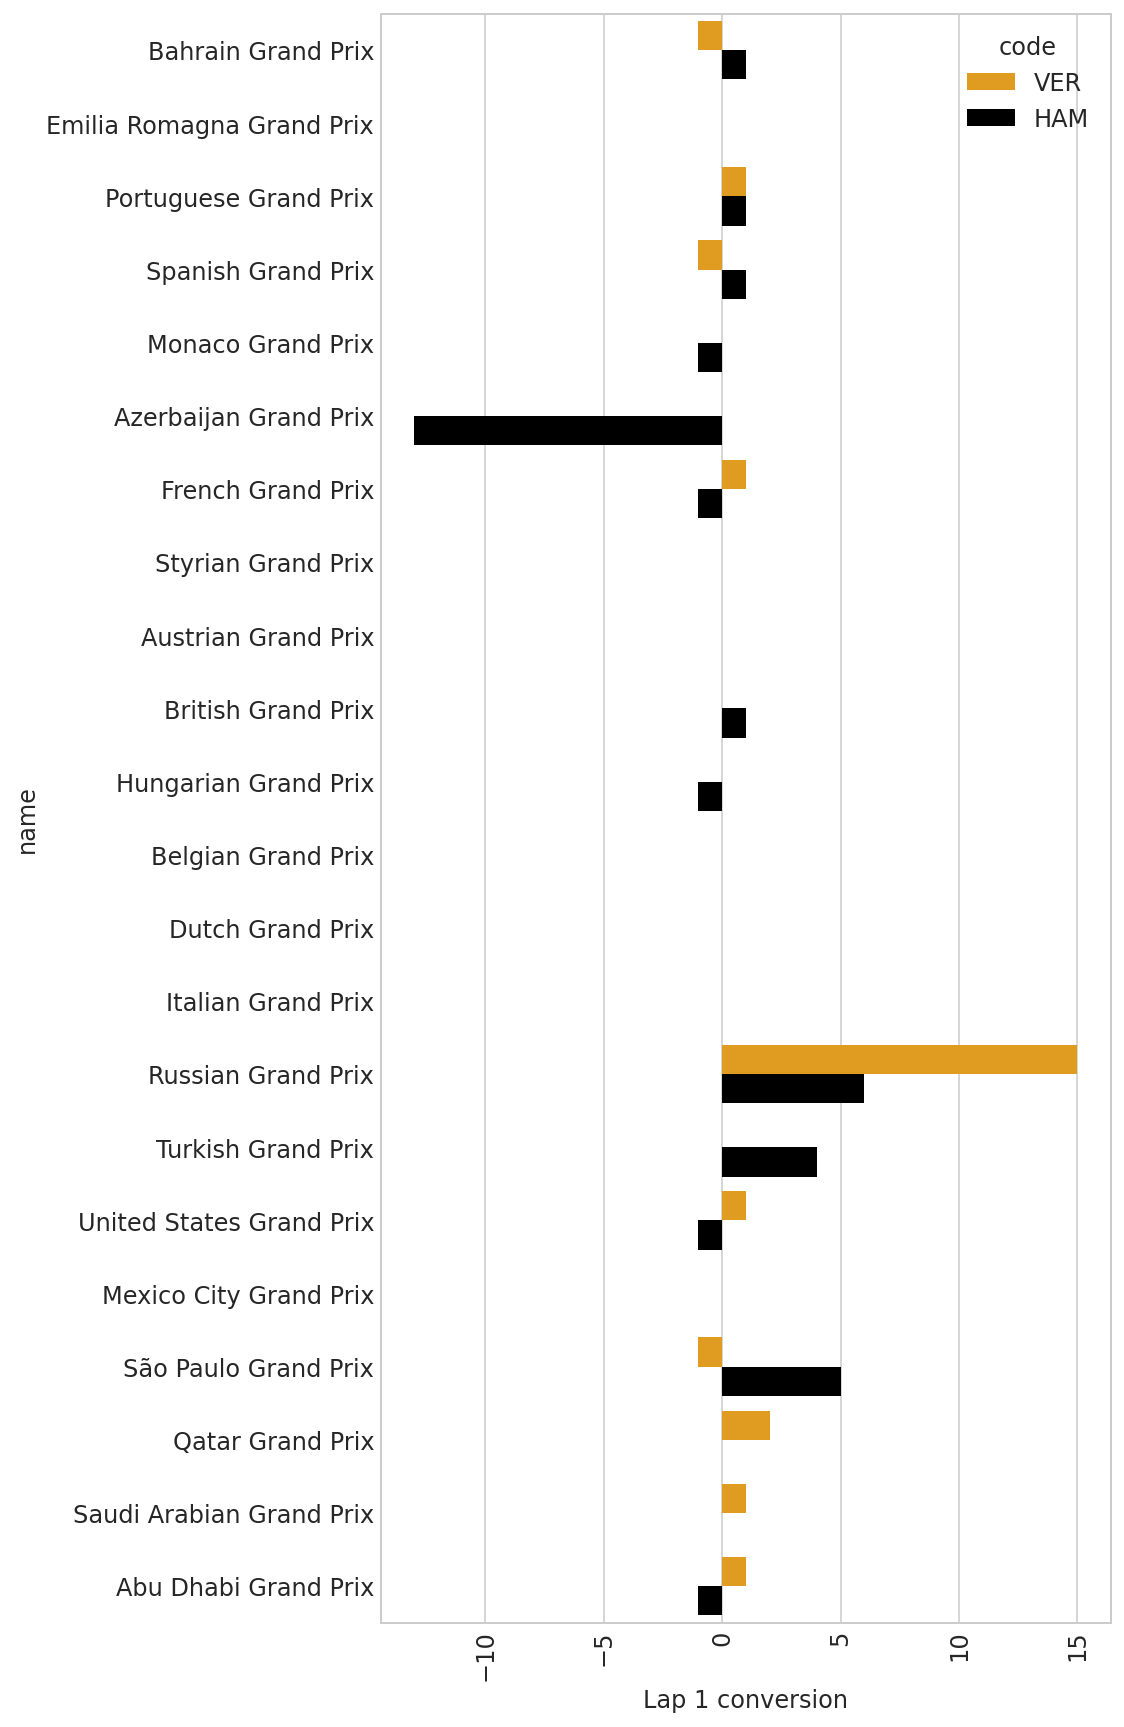

In [38]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=8,12
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.labelsize']=12
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12
sns.barplot(data=df_conversions,
            y='name', 
            x='Lap 1 conversion',
            hue='code',
            palette=['orange','black'])
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

<a id='7'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Conclusion</b>

The championship was close even if it was controvertial about who won, we can glean some insights from the data we've seen so far:
 - Hamilton generally does better in qualifying than Verstappen.
 - Verstappen tends to do better during races, able to gain positions throughout the race. Hamilton seems to start ahead and more or less stay ahead.
 - the pitstops for Hamilton in 2021 were about half-a-second faster than the pitstops for Verstappen. This was with some outliers removed. Penalties may have featured, but even so Redbull simply did not do as well as Mercedes.  
 - Hamilton's lap times started more consistent at the beginning of the season, whereas Verstappen was more 'all over the place', as the season progressed Verstappen became more consistent and Hamilton in more races became more inconsistent with the lap times.
 